In [1]:
''' This script trains a score-based model to learn a score function with the built-in singularity.'''

## Importing necessary libraries
import torch, random, shutil, os, numpy as np, torch.nn as nn
import matplotlib.pyplot as plt
from ema_pytorch import EMA

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setting up the plotting parameters
plt.rcParams.update({"text.usetex": True,"font.family": "sans-serif",'font.size': 18})

## Load data

<Figure size 200x200 with 0 Axes>

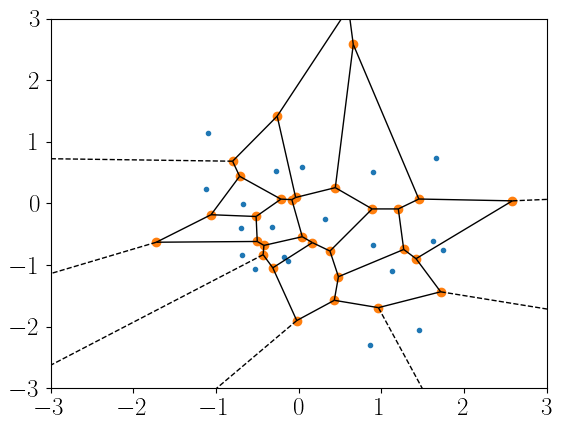

In [2]:
# Set seed manually for reproducibility
random.seed(1)
np.random.seed(1)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load data
data = torch.from_numpy(np.load("training_data.npy")).float()
N = data.shape[0]
dim = data.shape[1]

# plot data
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(data)
plt.figure(figsize=(2,2))
fig = voronoi_plot_2d(vor)
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()

## Define model

In [3]:
class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""  
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class score_edm(torch.nn.Module):
    '''
        Neural network to learn the score function
        Results in the paper use the default settings of width=256, depth=2, activation=ReLU
    '''
    def __init__(self, device, width=256, depth=2, embed_dim=8, activation=nn.ReLU, schedule=None):
        super().__init__()
        
        self.width = width
        self.depth = depth
        self.activation = activation()
        self.embed = GaussianFourierProjection(embed_dim, scale=1.0)
        net = []
        net.append(nn.Linear(2+embed_dim,self.width))
        net.append(self.activation)
        for _ in range(self.depth):
            net.append(nn.Linear(self.width,self.width))
            net.append(self.activation)
        net.append(nn.Linear(self.width,2))
        self.net = nn.Sequential(*net).to(device=device)
        self.training_mode = True
        self.schedule = schedule
        
    def forward(self, x, t):
        embed = self.embed(t.squeeze())
        x_in = torch.cat([x, embed], dim=-1)
        score = self.net(x_in).to(torch.float32)
        if self.training_mode == False:
            score = score / schedule.marginal_prob_std(t)[:,None]
        return score
    
def loss_func(net, X, schedule, denoising=False):
    '''
        Denoising score matching loss function (un-regularized)
    '''
    t = torch.rand([X.shape[0], 1], device=X.device)
    noise = torch.randn_like(X) 
    mean = (schedule.marginal_prob_mean(t)).to(X.device)
    std  = (schedule.marginal_prob_std(t)).to(X.device)
    x_tilde = mean * X + std * noise
    score = net(x_tilde, t)
    if denoising == True:
        loss = torch.mean((score + noise)**2, dim=(1))
    else:
        loss = torch.mean((std*score + noise)**2, dim=(1))
    return loss.mean()

from score_models import GMM_score, VE, VP

# Training parameters
n_epochs        = 300000 # maximum number of total epochs
lr              = 1e-3   # learning rate
depth           = 2      # Depth of the score network
plot_every      = 10000  # Plotting interval
embed_dim       = 8      # Dimension of the time embedding
path_to_save    = './experiments/Singularity/'
figures_path    = './figures/VP_NN_Singularity/'

# define schedule
schedule = VP() 
#schedule = VE()

# define width list
width_list = [8,16,32,64,128,256,512,1024]

## Train networks

In [15]:
for width in width_list:

    # Define network for non-denoising loss
    score_net = score_edm(device=device, width=width, depth=depth, embed_dim=embed_dim, activation=nn.ReLU)
    score_ema = EMA(score_net, beta=0.9999)

    # define optimizer
    optimizer = torch.optim.Adam(score_net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

    # Training loop for non-denoising loss
    for epoch in range(n_epochs):
        score_net.train()

        # shuffle data
        X = data.to(device) 
        X = X[torch.randperm(X.shape[0])]

        # evaluate loss and backpropagate
        loss = loss_func(score_net, X, schedule, denoising=False)
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        score_ema.update()
            
        # save results
        if (epoch+1) % plot_every == 0:
            print("epoch: {}, loss: {}".format(epoch, loss.item()))
            states = [score_net.state_dict(),score_ema.state_dict(),optimizer.state_dict()]
            torch.save(states, path_to_save+'nonsingular_width'+str(width)+'_checkpoint_'+str(epoch)+'.pth')

    # Define network for denoising loss
    score_net_singular = score_edm(device=device, width=width, depth=depth, embed_dim=embed_dim, activation=nn.ReLU)
    score_ema_singular = EMA(score_net_singular, beta=0.9999)

    # define optimizer
    optimizer_singular = torch.optim.Adam(score_net_singular.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

    # Training loop for non-denoising loss
    for epoch in range(n_epochs):
        score_net.train()

        # shuffle data
        X = data.to(device) 
        X = X[torch.randperm(X.shape[0])]

        # evaluate loss and backpropagate
        loss = loss_func(score_net_singular, X, schedule, denoising=True)
        optimizer_singular.zero_grad()
        loss.backward()

        optimizer_singular.step()
        score_ema_singular.update()
            
        # save results
        if (epoch+1) % plot_every == 0:
            print("epoch: {}, loss: {}".format(epoch, loss.item()))
            states = [score_net_singular.state_dict(),score_ema_singular.state_dict(),optimizer_singular.state_dict()]
            torch.save(states, path_to_save+'singular_width'+str(width)+'checkpoint_'+str(epoch)+'.pth')

epoch: 9999, loss: 0.6376653909683228
epoch: 19999, loss: 0.36694830656051636
epoch: 29999, loss: 0.48131585121154785
epoch: 39999, loss: 0.4638163447380066
epoch: 49999, loss: 0.6455990672111511
epoch: 59999, loss: 0.35834866762161255
epoch: 69999, loss: 0.9502289891242981
epoch: 79999, loss: 0.508803129196167
epoch: 89999, loss: 0.6264917254447937
epoch: 99999, loss: 0.6017135381698608
epoch: 109999, loss: 0.7643085718154907
epoch: 119999, loss: 0.4526553153991699
epoch: 129999, loss: 0.3486505448818207
epoch: 139999, loss: 0.790030300617218
epoch: 149999, loss: 0.31928038597106934
epoch: 159999, loss: 0.46335369348526
epoch: 169999, loss: 0.5597503185272217
epoch: 179999, loss: 0.33873066306114197
epoch: 189999, loss: 0.789188027381897
epoch: 199999, loss: 0.5567223429679871
epoch: 209999, loss: 0.2552831470966339
epoch: 219999, loss: 0.30814510583877563
epoch: 229999, loss: 0.6926981210708618
epoch: 239999, loss: 0.46117067337036133
epoch: 249999, loss: 0.45573607087135315
epoch: 2

## Generate samples

/var/folders/tc/106jyy157sv7rxwtk7hgpqf00000gn/T/ipykernel_72318/2214133244.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  res_loc = torch.tensor(samples_x, device=latents.device, dtype=torch.float32).reshape(lat_shape)
/var/folders/tc/106jyy157sv7rxwtk7hgpqf00000gn/T/ipykernel_72318/2214133244.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

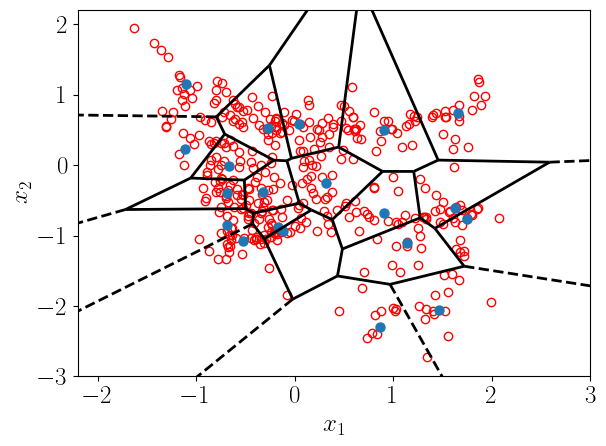

<Figure size 640x480 with 0 Axes>

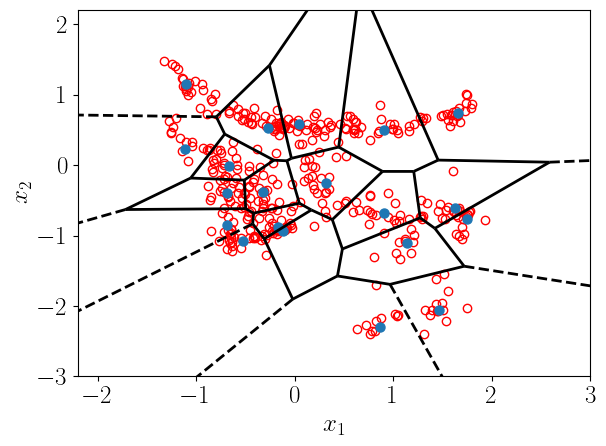

<Figure size 640x480 with 0 Axes>

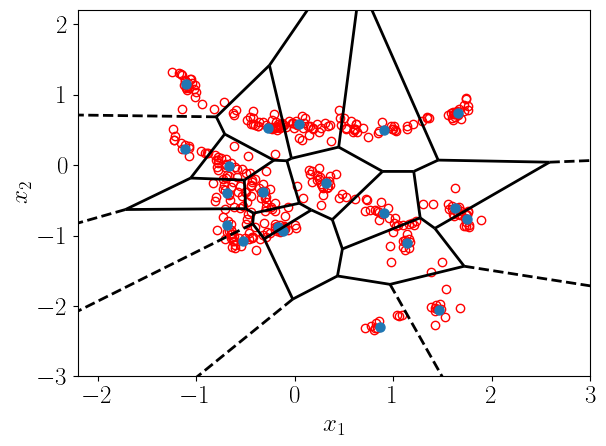

<Figure size 640x480 with 0 Axes>

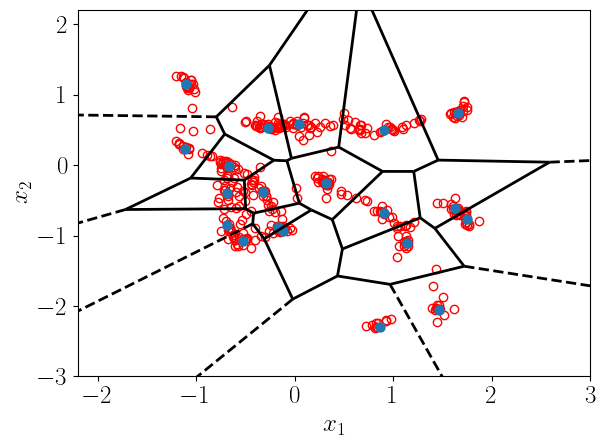

<Figure size 640x480 with 0 Axes>

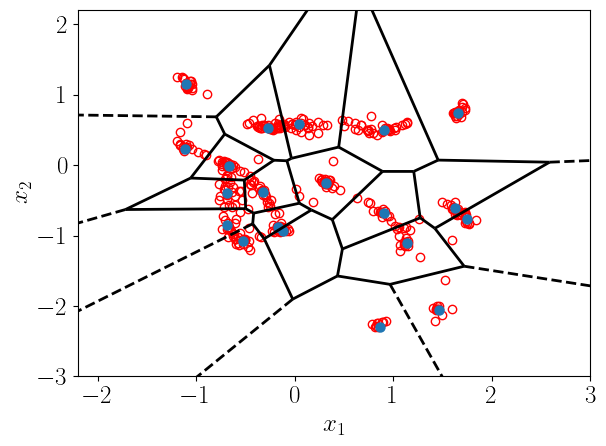

<Figure size 640x480 with 0 Axes>

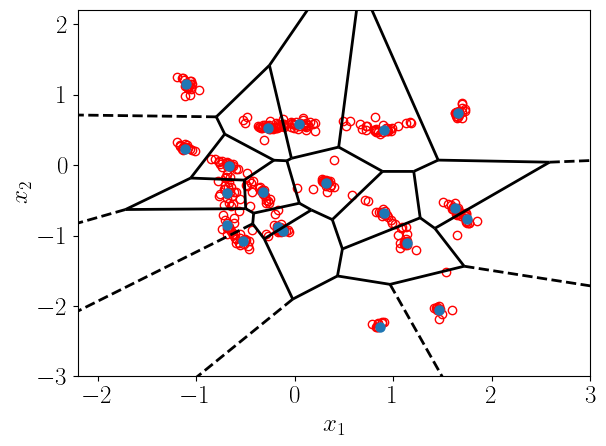

<Figure size 640x480 with 0 Axes>

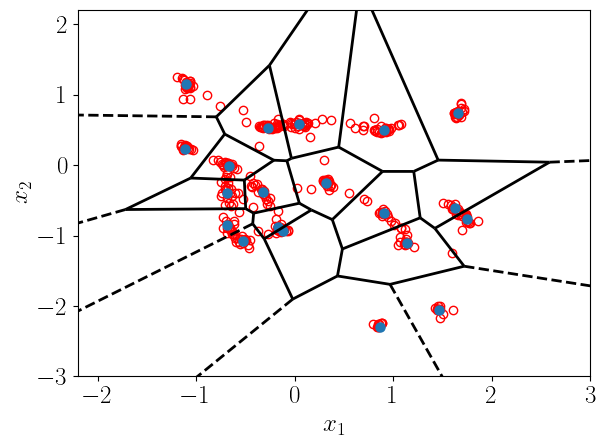

<Figure size 640x480 with 0 Axes>

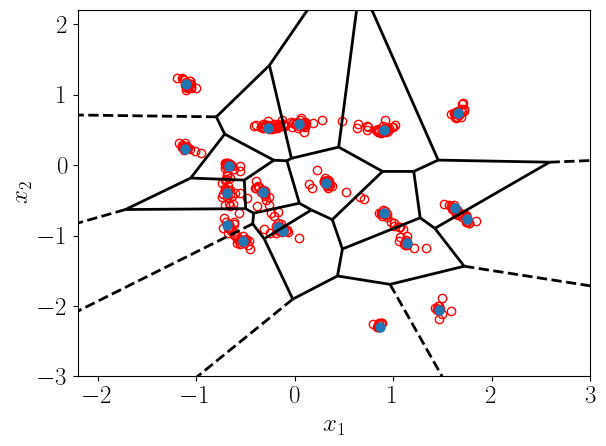

<Figure size 640x480 with 0 Axes>

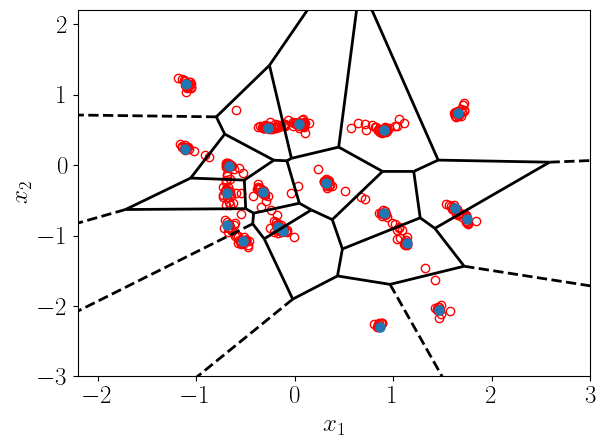

<Figure size 640x480 with 0 Axes>

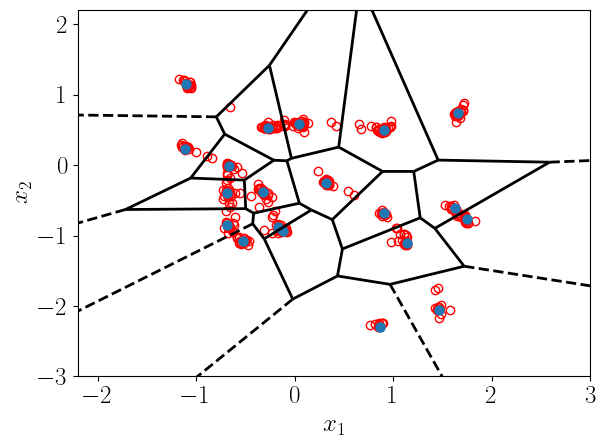

<Figure size 640x480 with 0 Axes>

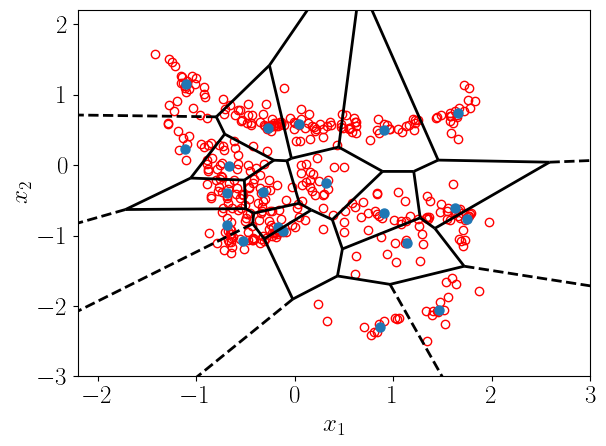

<Figure size 640x480 with 0 Axes>

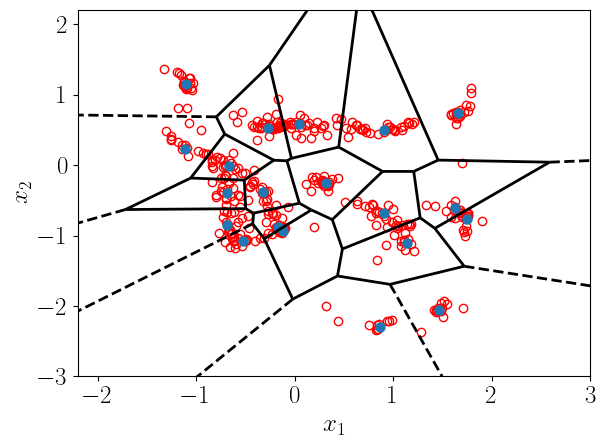

<Figure size 640x480 with 0 Axes>

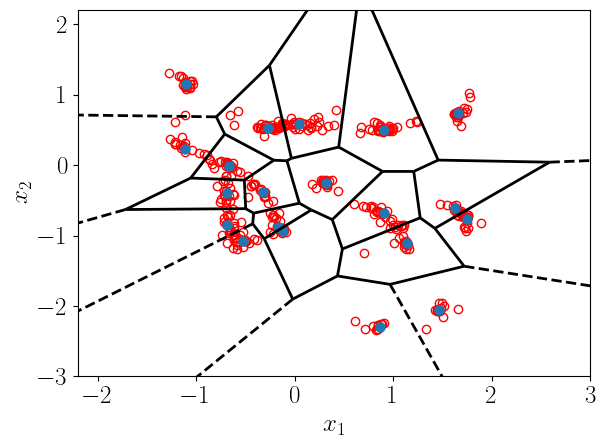

<Figure size 640x480 with 0 Axes>

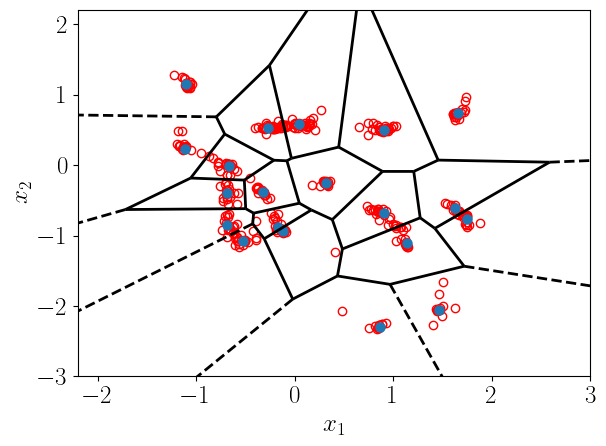

<Figure size 640x480 with 0 Axes>

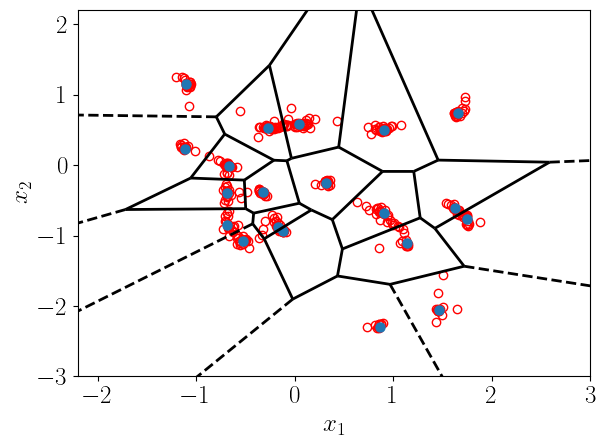

<Figure size 640x480 with 0 Axes>

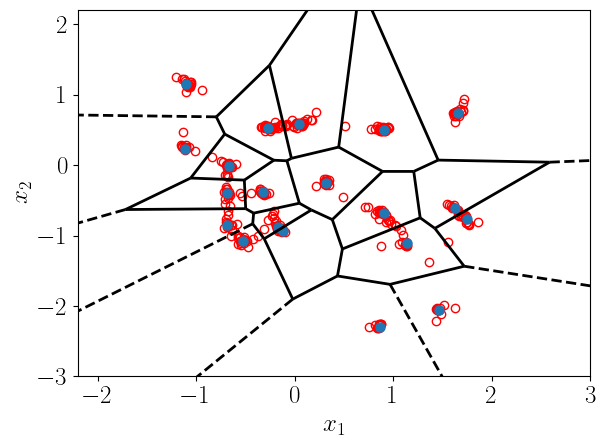

<Figure size 640x480 with 0 Axes>

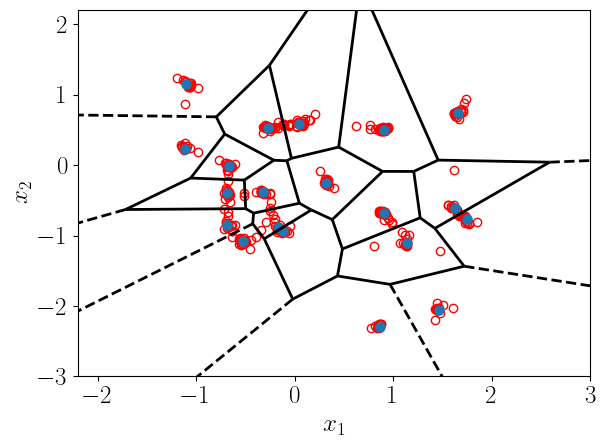

<Figure size 640x480 with 0 Axes>

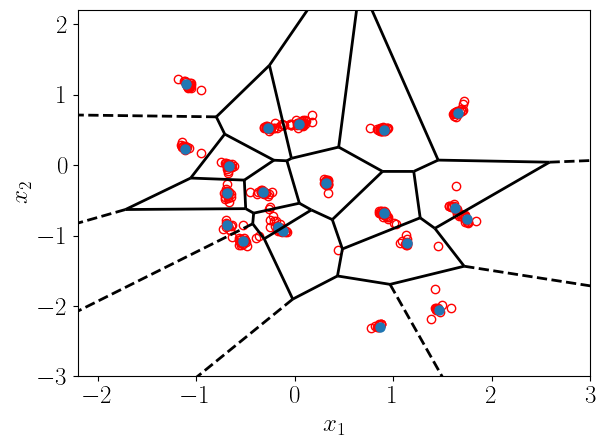

<Figure size 640x480 with 0 Axes>

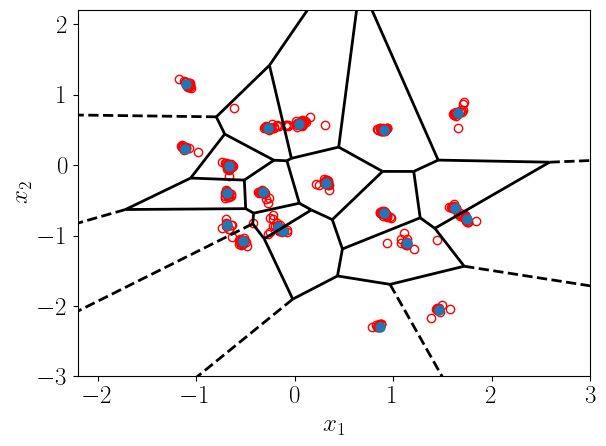

<Figure size 640x480 with 0 Axes>

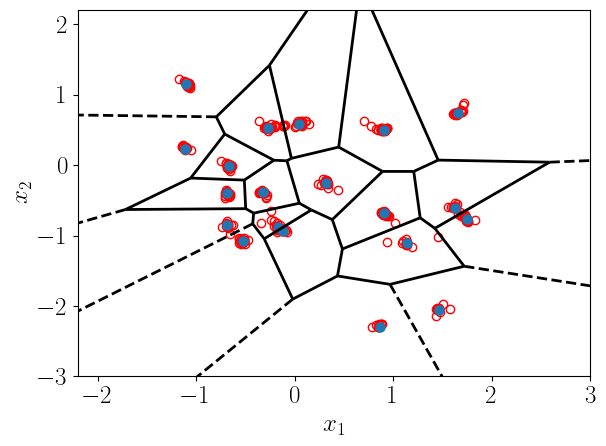

In [5]:
# define latents for sampling and integrate model
batch_size = 1000
latents = torch.randn(batch_size, dim)

# define points for plotting
plotting_pts = 400

# define network names 
network_names = ['nonsingular','singular']

# epoch for plotting
epoch_plotting = np.arange(plot_every-1, n_epochs, plot_every)

# Define network
score_net = score_edm(device=device, width=width, depth=depth, embed_dim=embed_dim, activation=nn.ReLU)
score_ema = EMA(score_net, beta=0.9999)

for network in network_names:
    for epoch in epoch_plotting:
        # load model
        score_ema.load_state_dict(torch.load(path_to_save+network+'_checkpoint_'+str(epoch)+'.pth')[1])
        if network == 'singular':
            score_ema.online_model.training_mode = False
            score_ema.ema_model.training_mode    = False
            score_ema.online_model.schedule      = schedule
            score_ema.ema_model.schedule         = schedule
        # integrate model
        samples_t, samples_x = schedule.ODEsampler(score_ema, latents, T0=1.0, T1=0.)
        # extract final samples
        lat_shape = [batch_size, 2, len(samples_t)]
        res_loc = torch.tensor(samples_x, device=latents.device, dtype=torch.float32).reshape(lat_shape)
        final_samples = res_loc[:,:,-1]
        # plot generated samples
        plt.figure()
        fig = voronoi_plot_2d(vor, show_vertices=False, line_width=2, point_size=13)
        plt.plot(final_samples[:plotting_pts,0], final_samples[:plotting_pts,1], 'or', mfc='none', zorder=0)
        plt.xlabel('$x_1$')
        plt.ylabel('$x_2$')
        plt.xlim(-2.2,3)
        plt.ylim(-3,2.2)
        #plt.title(network + ': epoch' + str(epoch))
        plt.tight_layout()
        plt.savefig(figures_path+network+'_epoch'+str(epoch)+'.pdf')


## Plot fraction of collapsed points

In [9]:
# define latents for sampling and integrate model
batch_size = 1000
latents = torch.randn(batch_size, dim)

# define tolerances
tol_list = [1e-2, 5e-2, 1e-1, 5e-1]

# define points for plotting
plotting_pts = 400

# define network names 
network_names = ['nonsingular','singular']

# epoch for plotting
epoch_plotting = np.arange(plot_every-1, n_epochs, plot_every)

# define array to store counts
count_data = np.zeros((len(tol_list), len(network_names), len(width_list), len(epoch_plotting)))

for (k,network) in enumerate(network_names):
    for (l,width) in enumerate(width_list):
        print(network, width)
        # Define network
        score_net = score_edm(device=device, width=width, depth=depth, embed_dim=embed_dim, activation=nn.ReLU)
        score_ema = EMA(score_net, beta=0.9999)
        for (m,epoch) in enumerate(epoch_plotting):
            # load model
            if network == 'singular':
                score_ema.load_state_dict(torch.load(path_to_save+network+'_width'+str(width)+'checkpoint_'+str(epoch)+'.pth')[1])
                score_ema.online_model.training_mode = False
                score_ema.ema_model.training_mode    = False
                score_ema.online_model.schedule      = schedule
                score_ema.ema_model.schedule         = schedule
            else:
                score_ema.load_state_dict(torch.load(path_to_save+network+'_width'+str(width)+'_checkpoint_'+str(epoch)+'.pth')[1])
            # integrate model
            samples_t, samples_x = schedule.ODEsampler(score_ema, latents, T0=1.0, T1=0.)
            # extract final samples
            lat_shape = [batch_size, 2, len(samples_t)]
            res_loc = torch.tensor(samples_x, device=latents.device, dtype=torch.float32).reshape(lat_shape)
            final_samples = res_loc[:,:,-1]
            # check how close each point is to a data point
            for (j,tolerance) in enumerate(tol_list):
                count = 0
                for i in range(batch_size):
                    dist = torch.sqrt(torch.sum((final_samples[i,:] - torch.tensor(data, dtype=torch.float32))**2, axis=1))
                    if torch.min(dist) < tolerance:
                        count += 1
                count_data[j,k,l,m] = count/batch_size


nonsingular 8


/var/folders/tc/106jyy157sv7rxwtk7hgpqf00000gn/T/ipykernel_1178/1447883280.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  res_loc = torch.tensor(samples_x, device=latents.device, dtype=torch.float32).reshape(lat_shape)
/var/folders/tc/106jyy157sv7rxwtk7hgpqf00000gn/T/ipykernel_1178/1447883280.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dist = torch.sqrt(torch.sum((final_samples[i,:] - torch.tensor(data, dtype=torch.float32))**2, axis=1))


nonsingular 16
nonsingular 32
nonsingular 64
nonsingular 128
nonsingular 256
nonsingular 512
nonsingular 1024
singular 8
singular 16
singular 32
singular 64
singular 128
singular 256
singular 512
singular 1024


/var/folders/tc/106jyy157sv7rxwtk7hgpqf00000gn/T/ipykernel_1178/2169683765.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


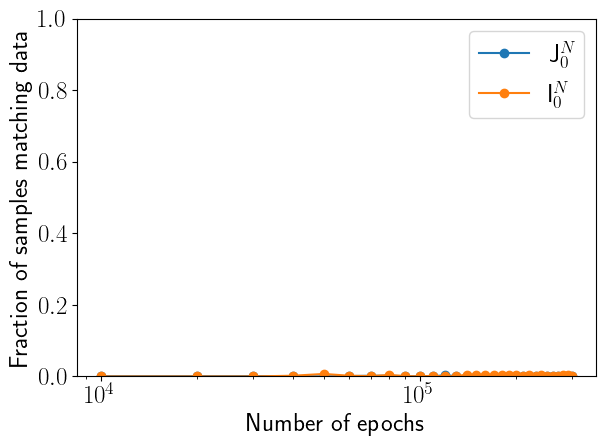

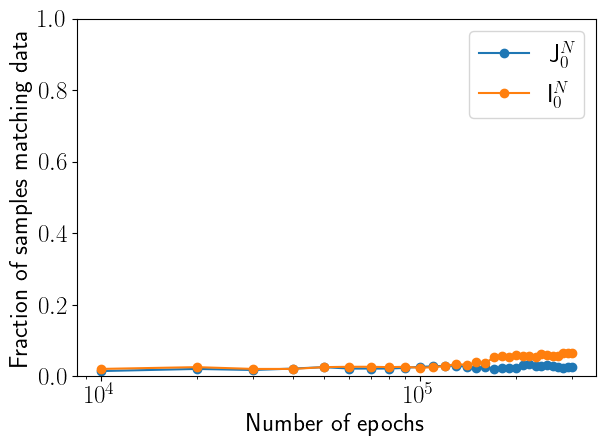

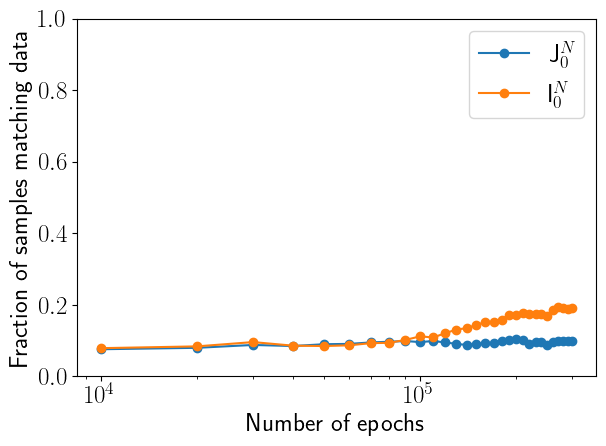

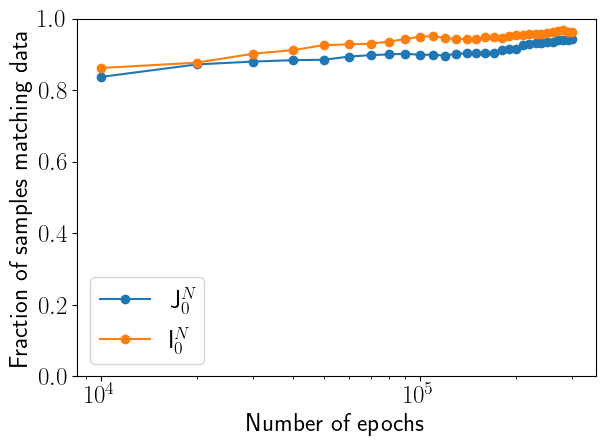

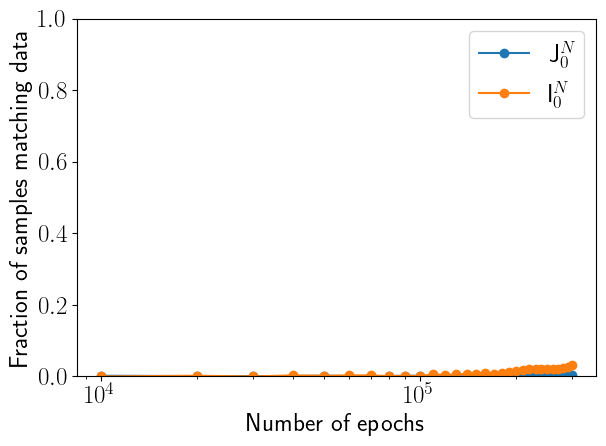

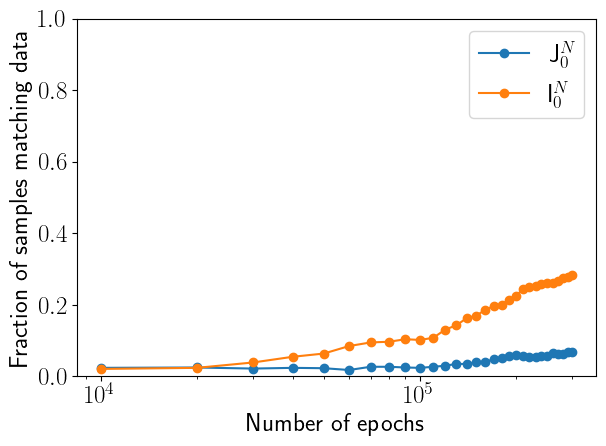

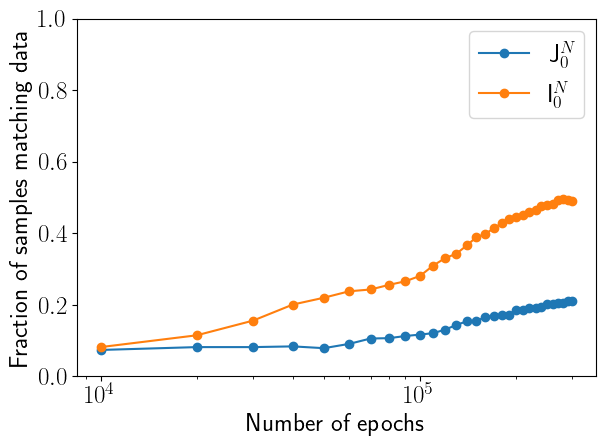

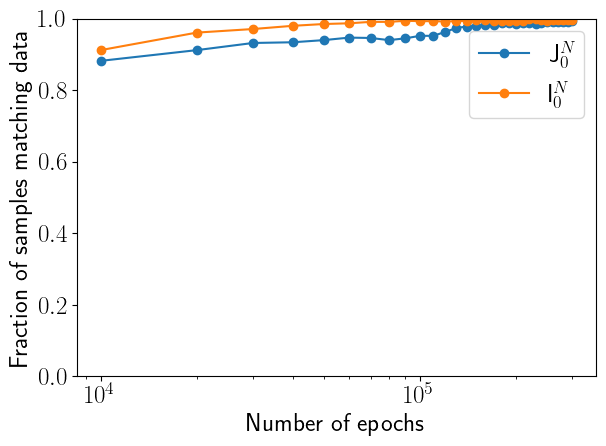

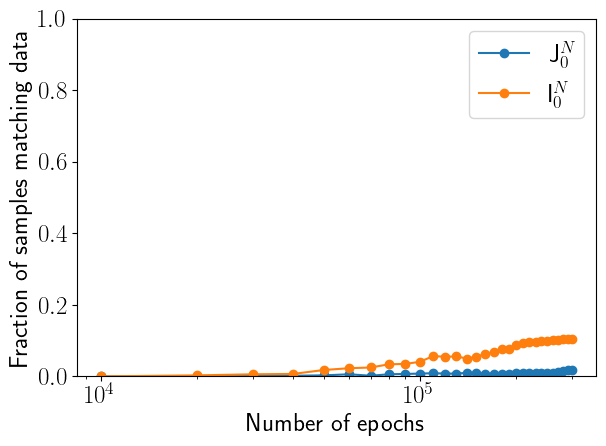

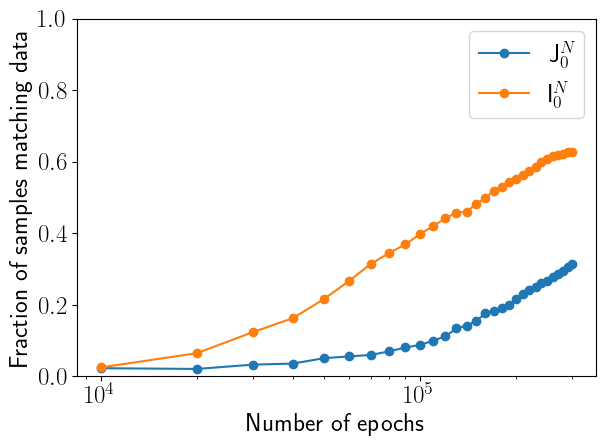

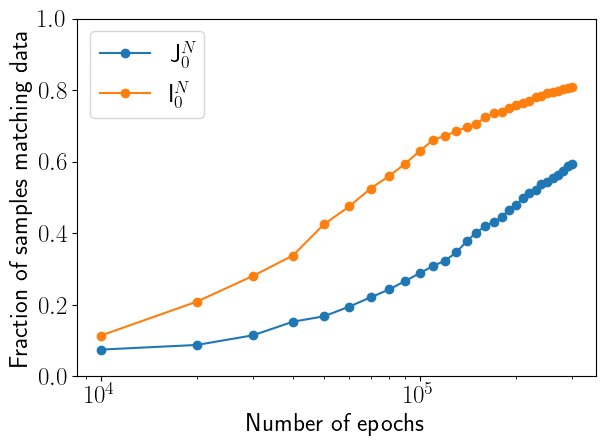

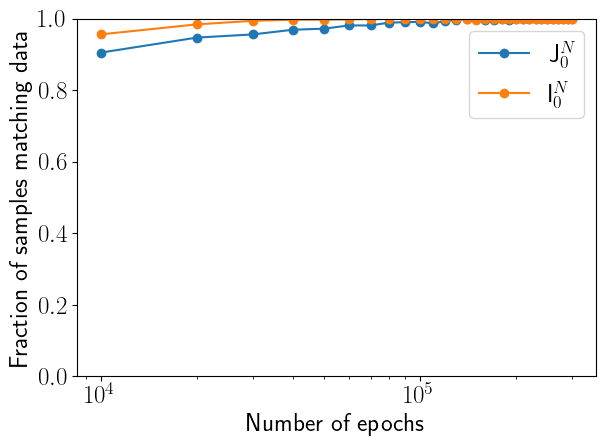

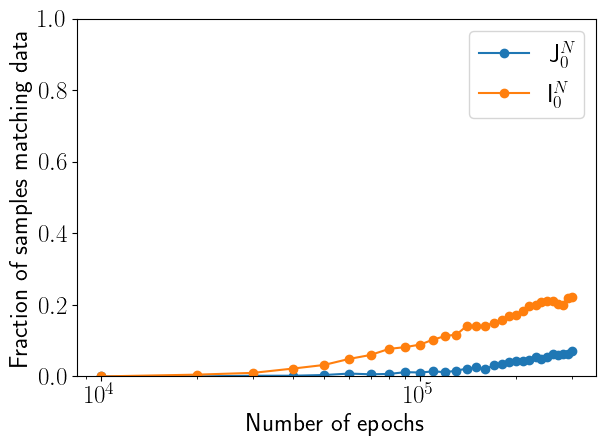

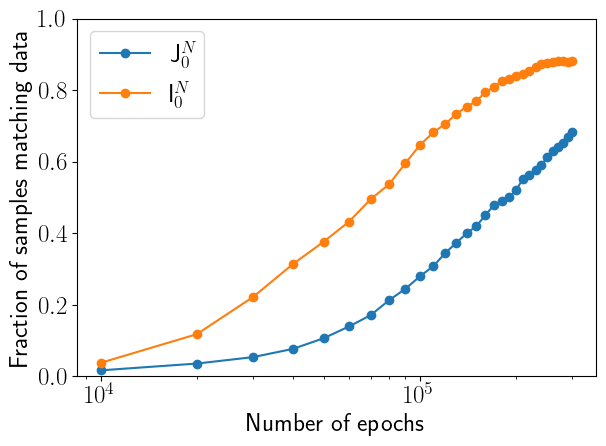

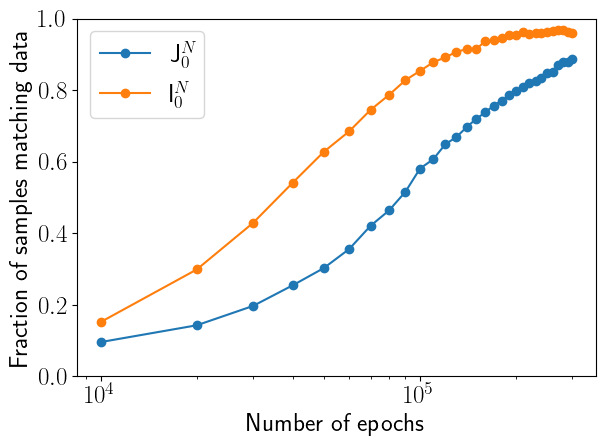

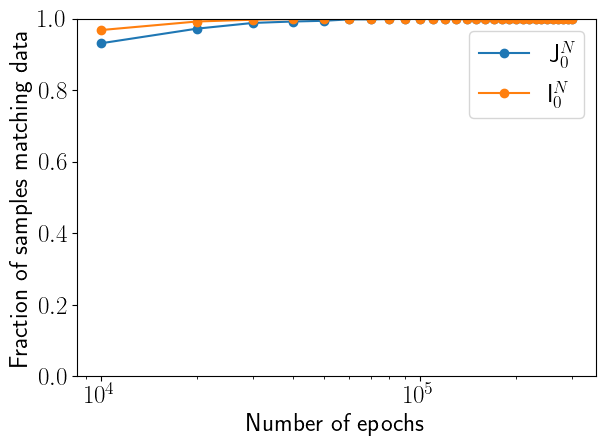

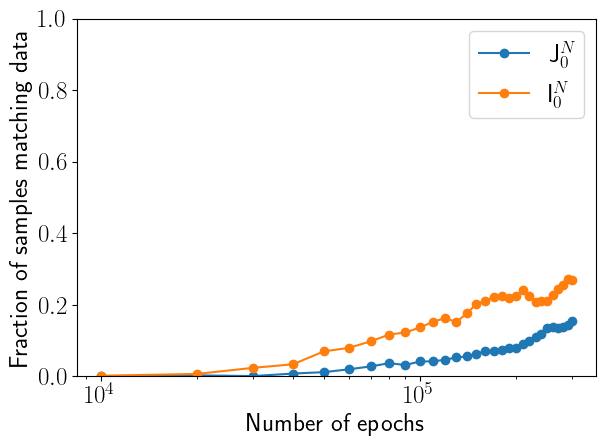

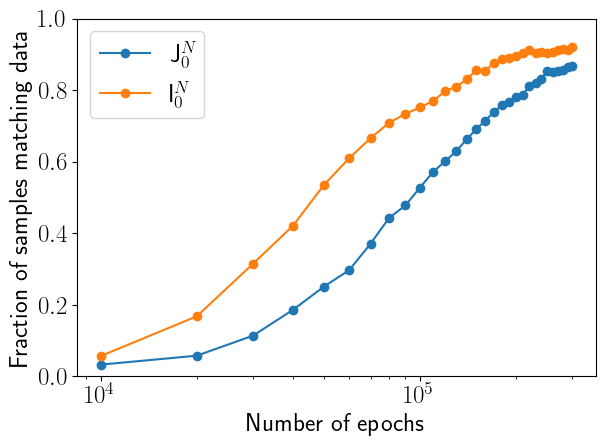

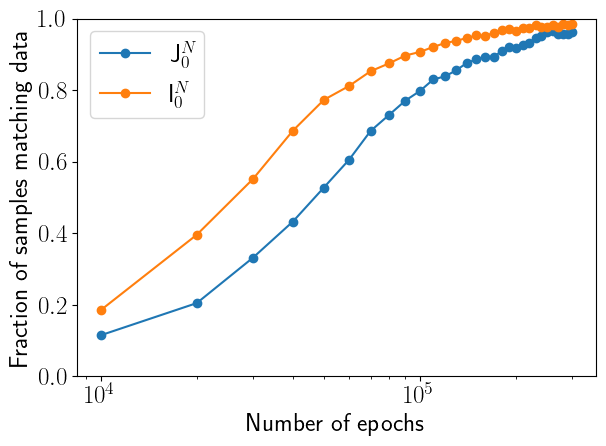

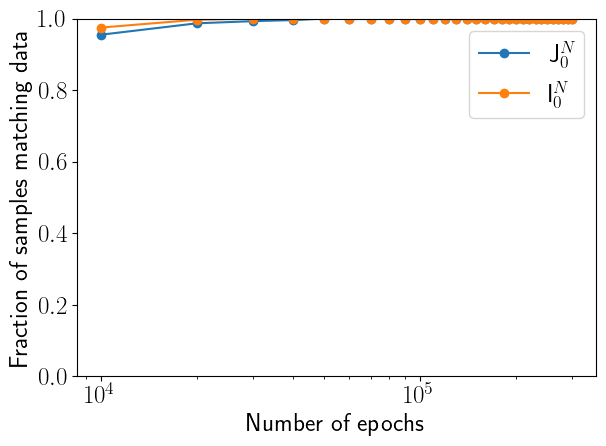

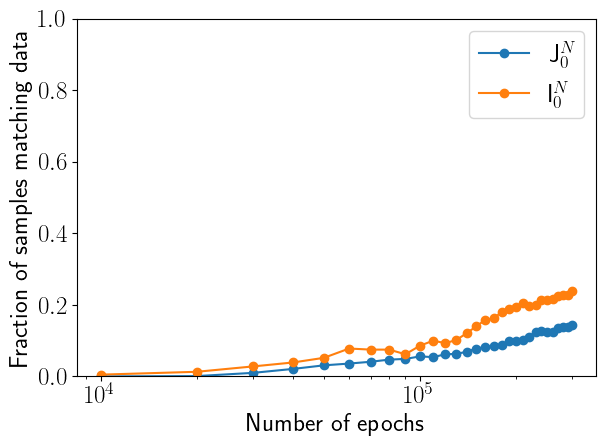

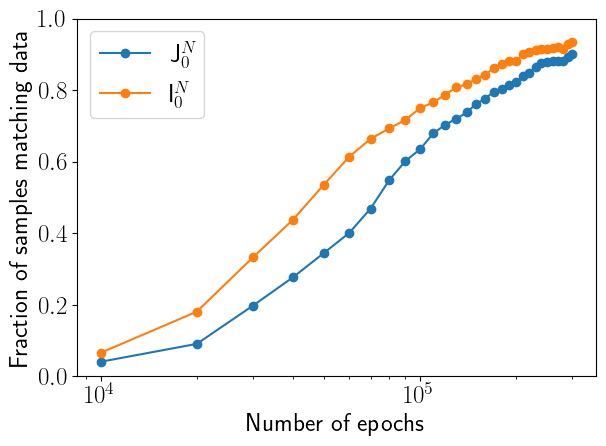

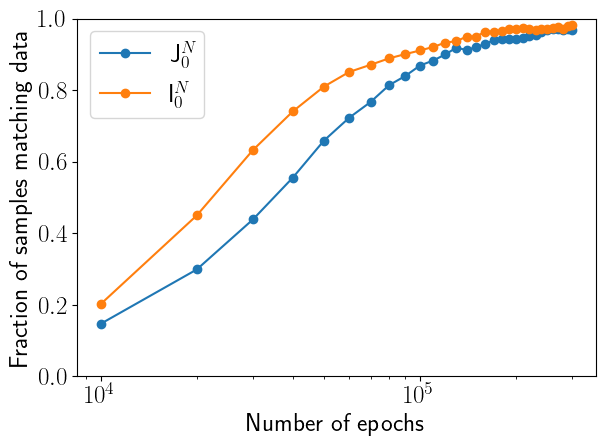

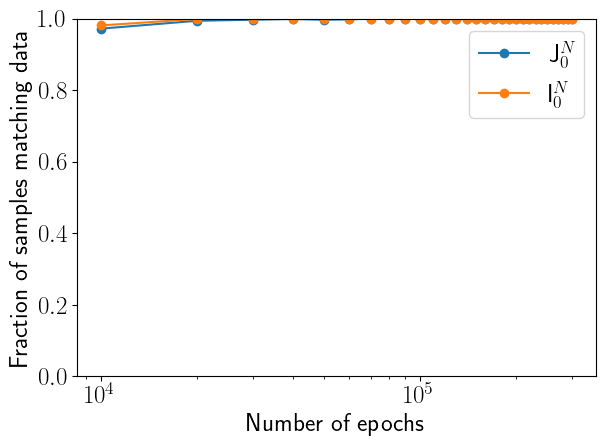

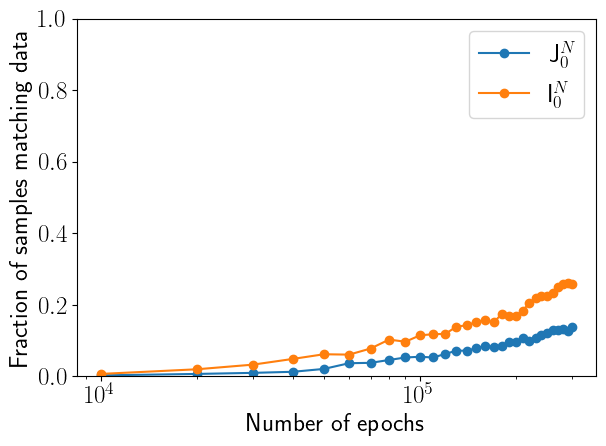

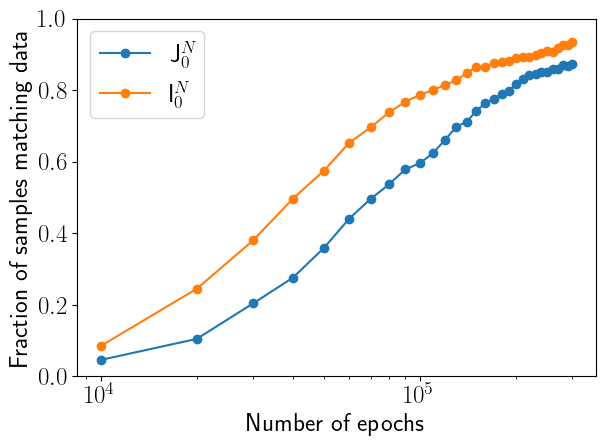

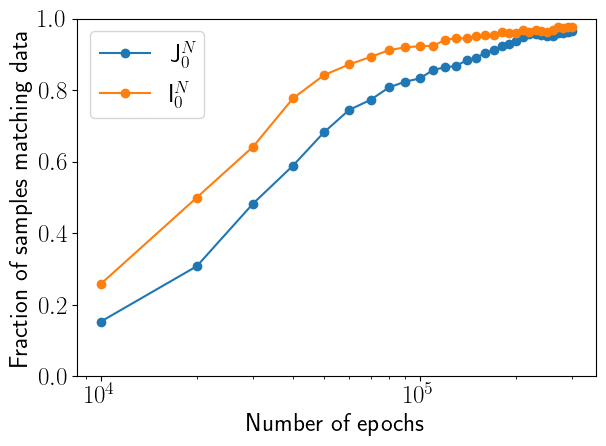

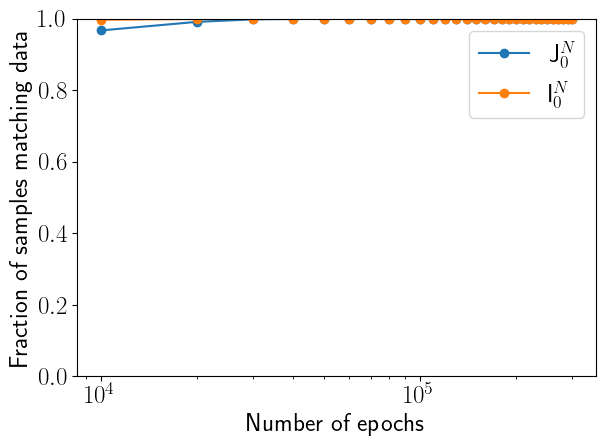

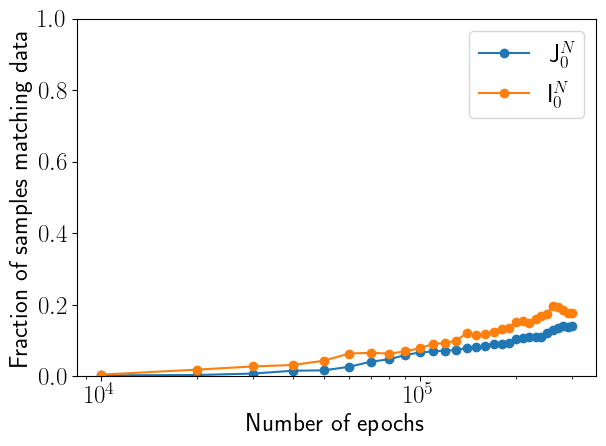

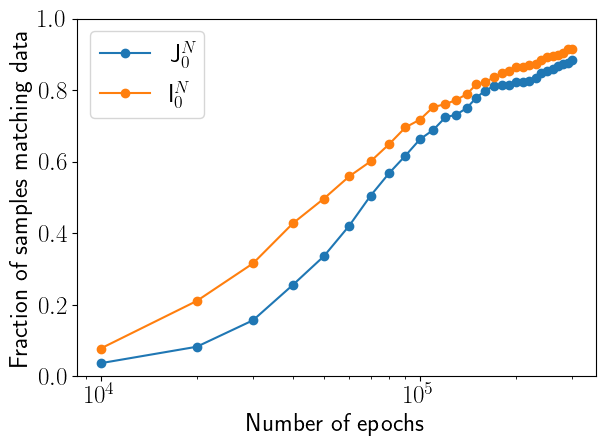

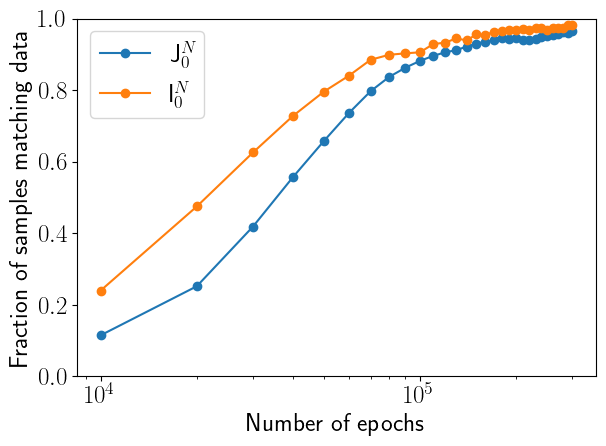

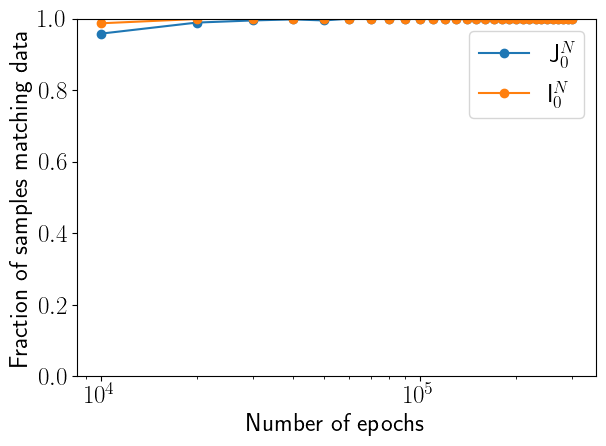

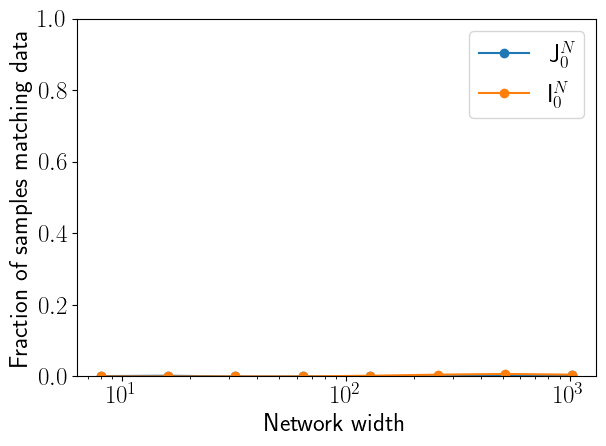

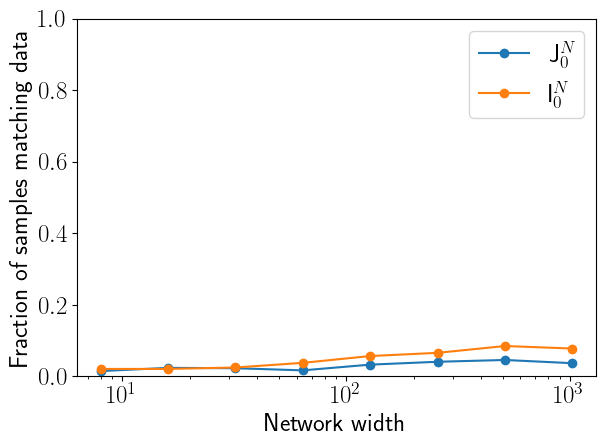

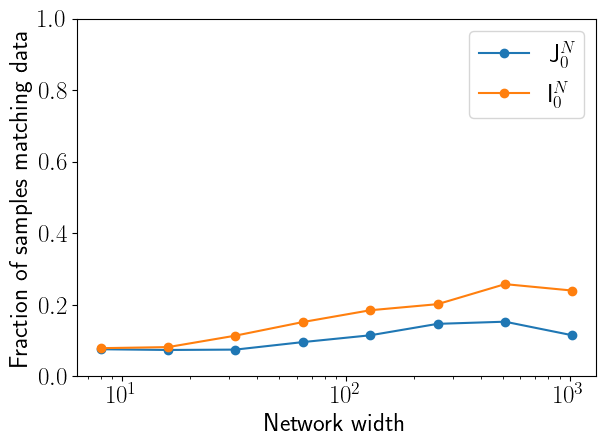

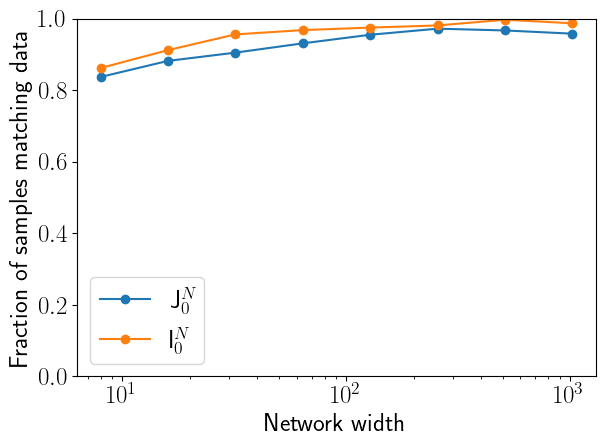

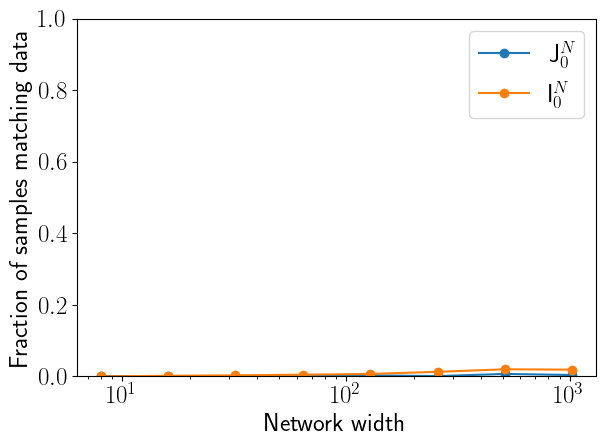

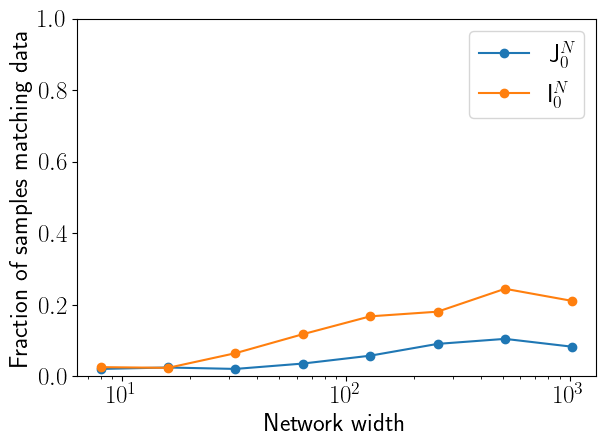

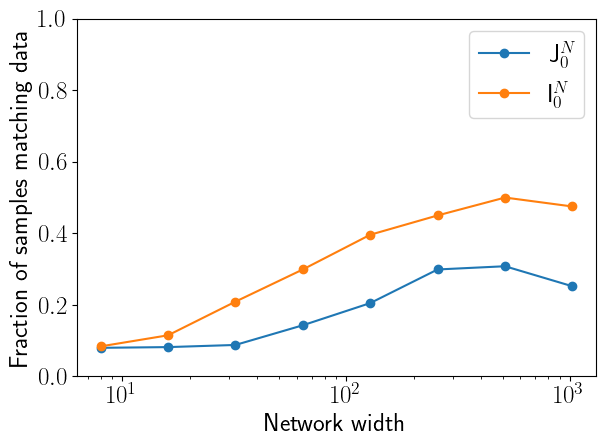

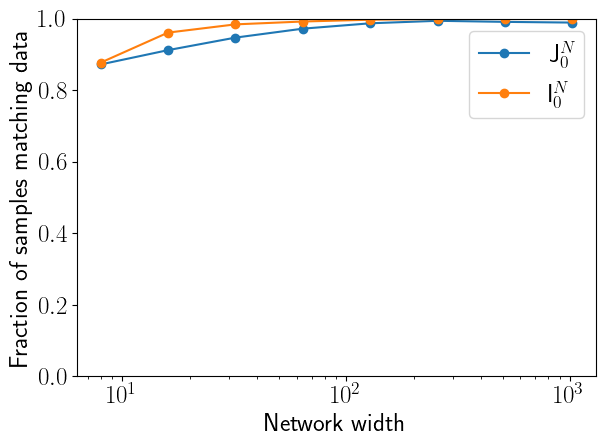

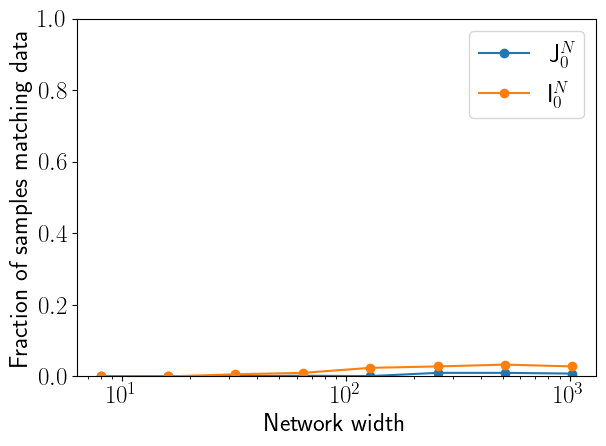

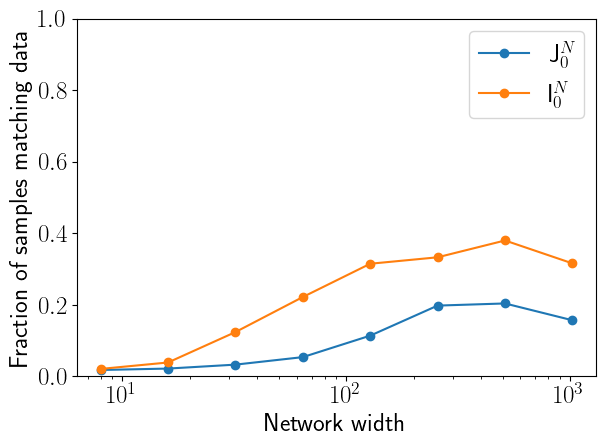

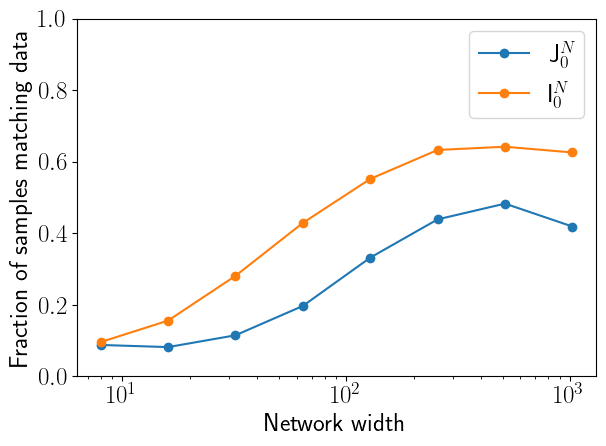

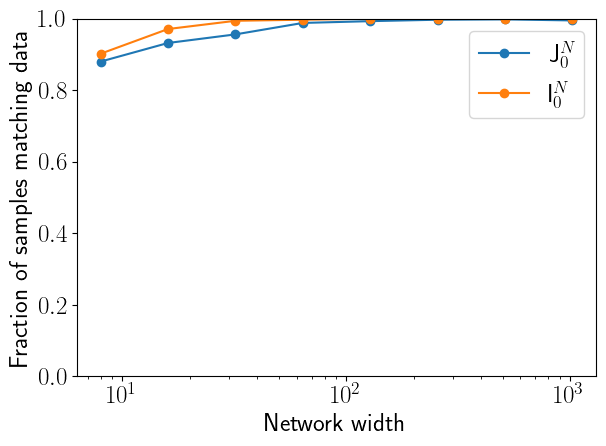

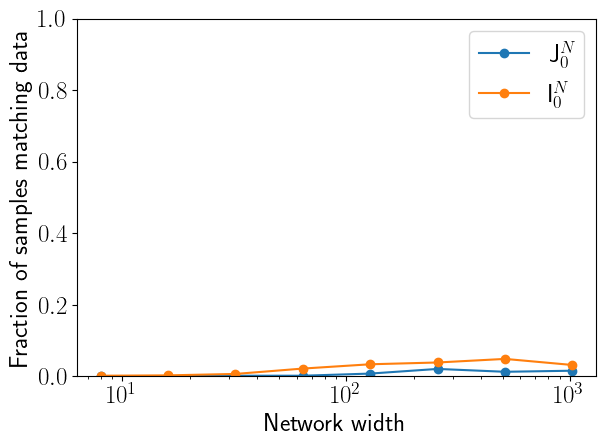

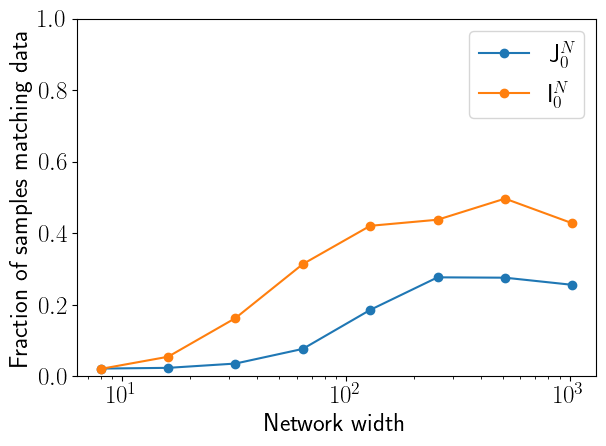

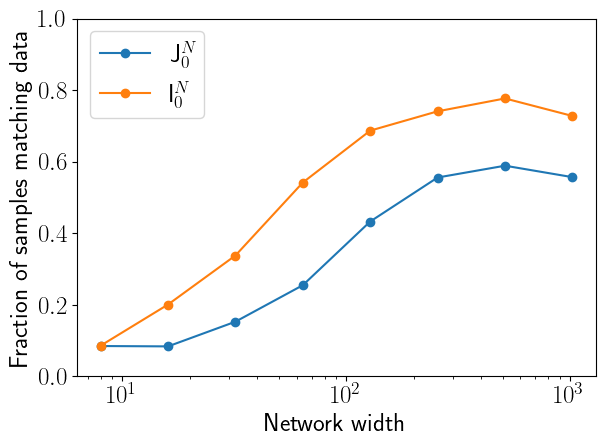

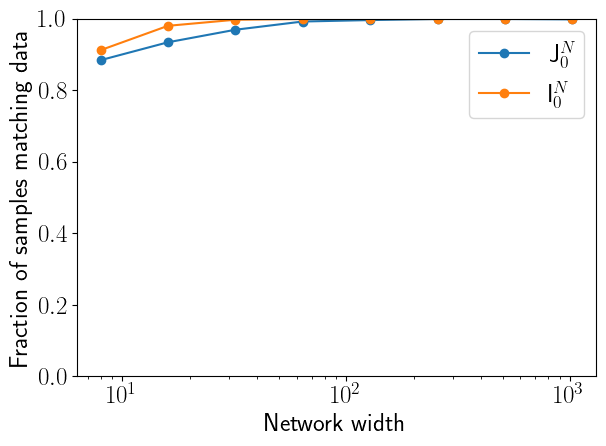

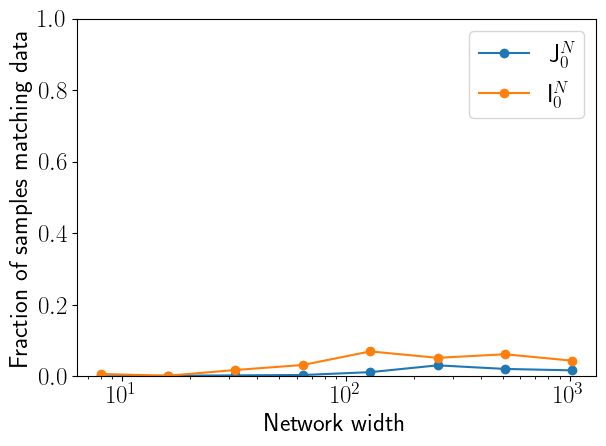

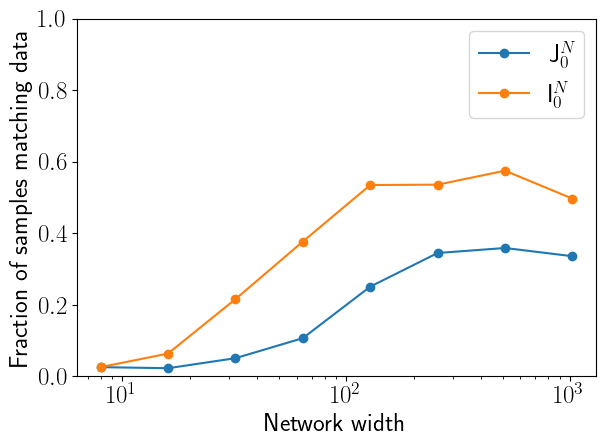

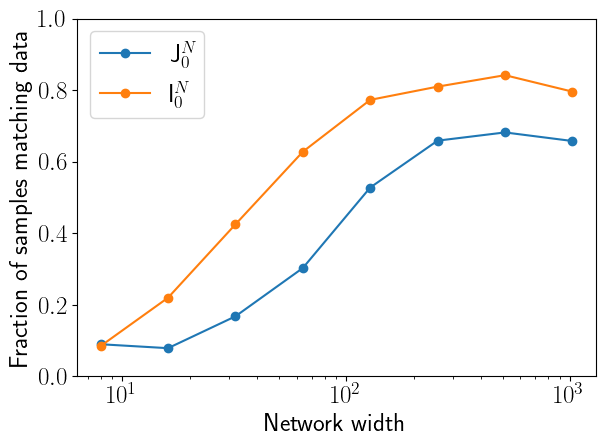

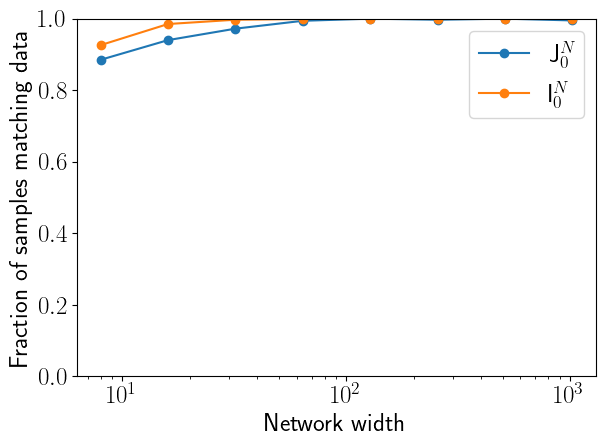

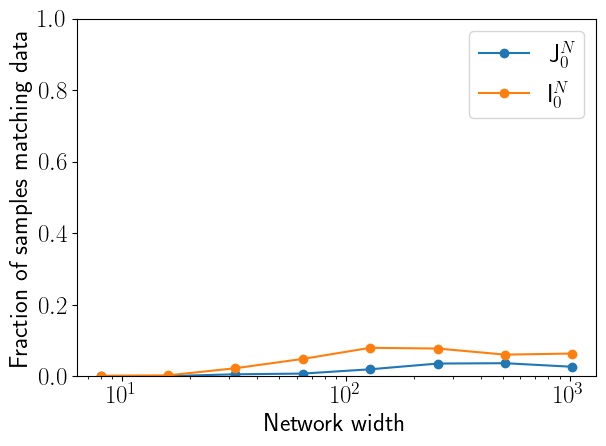

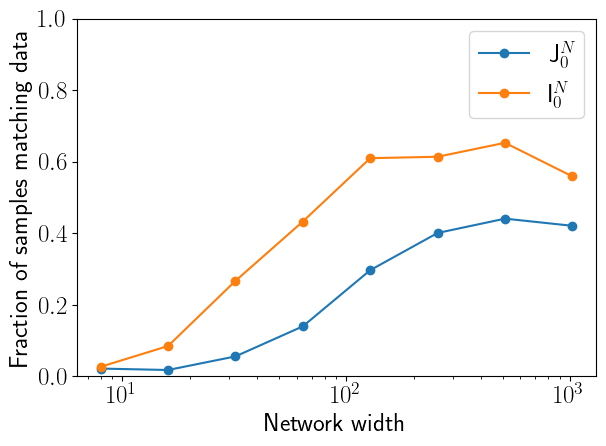

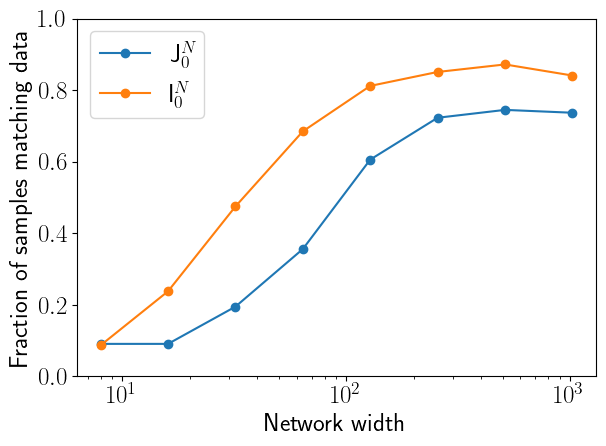

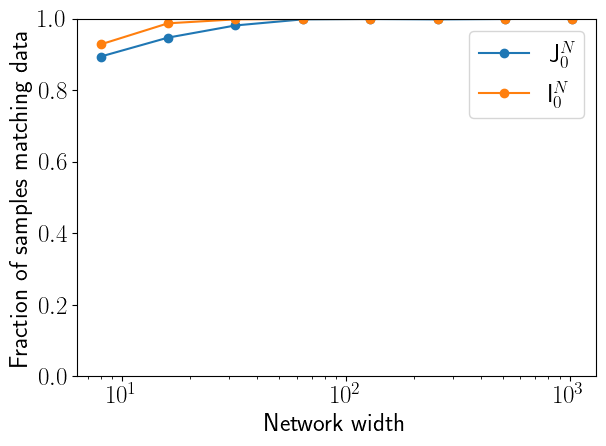

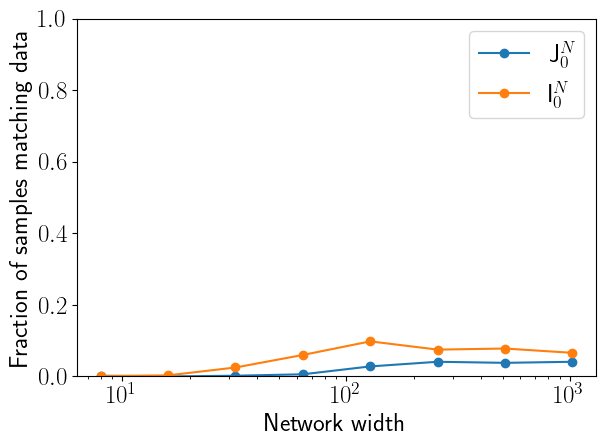

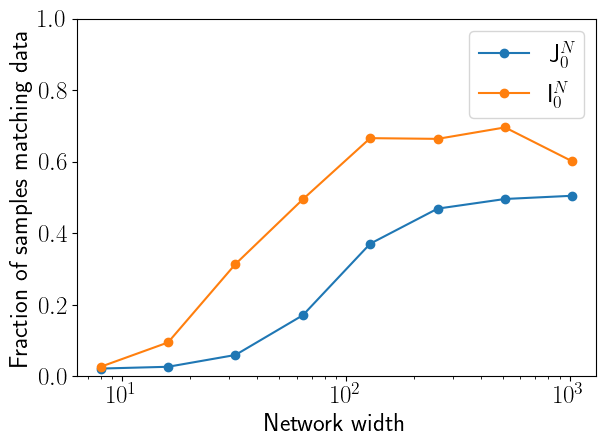

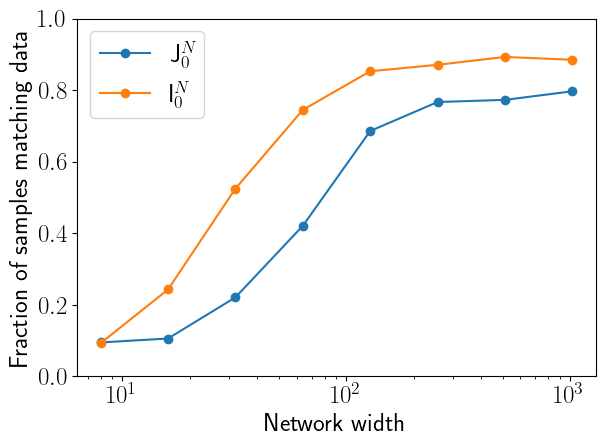

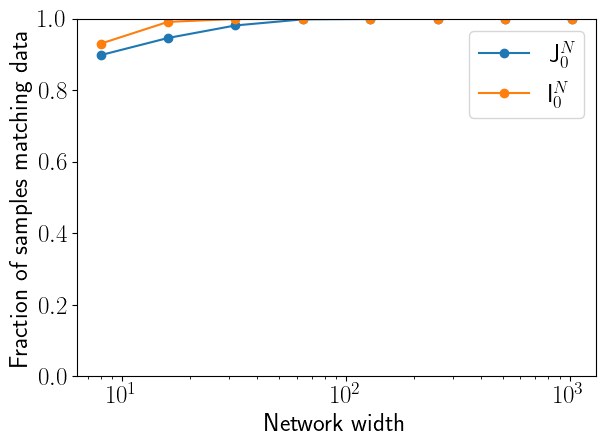

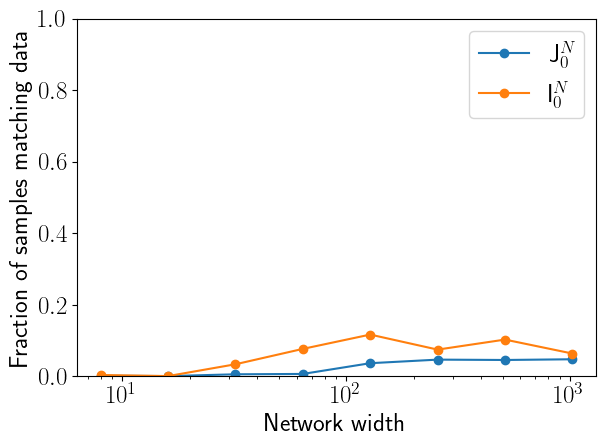

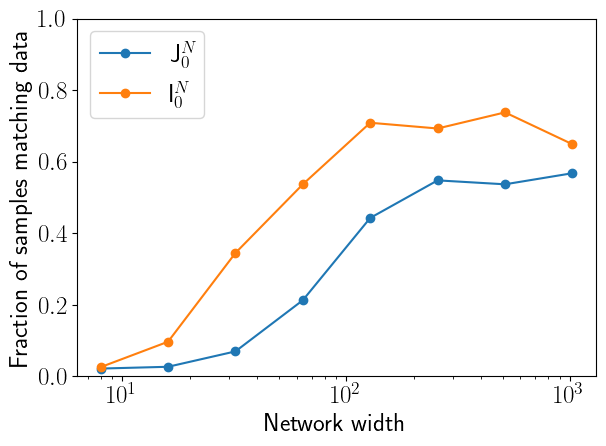

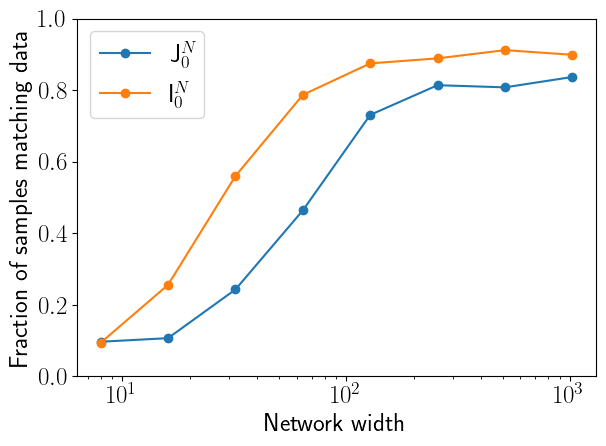

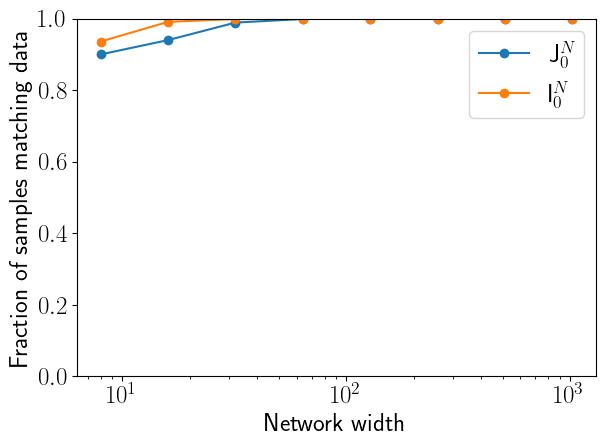

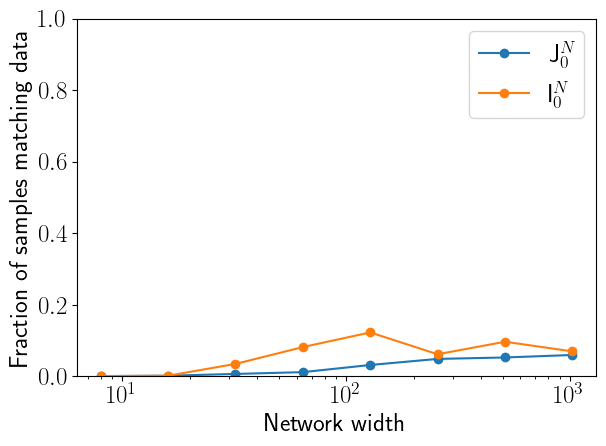

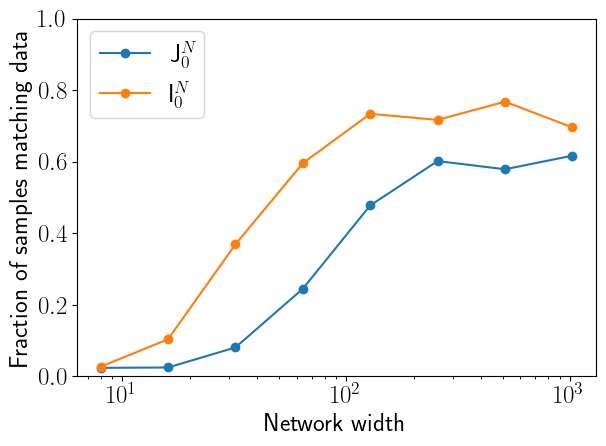

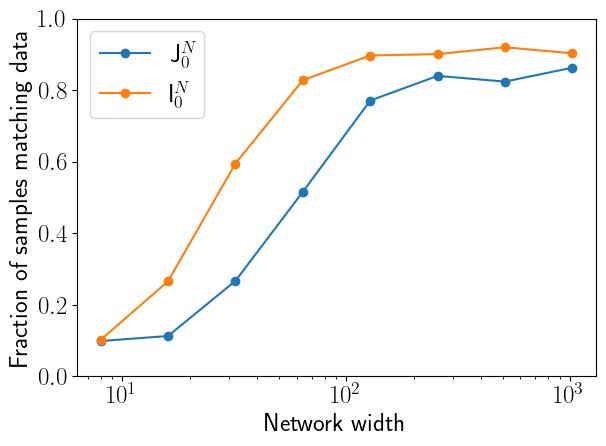

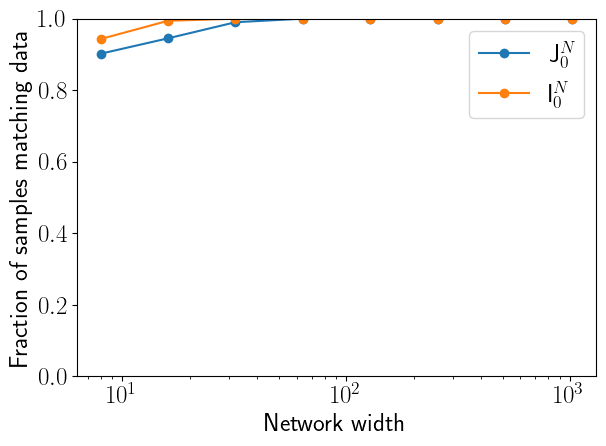

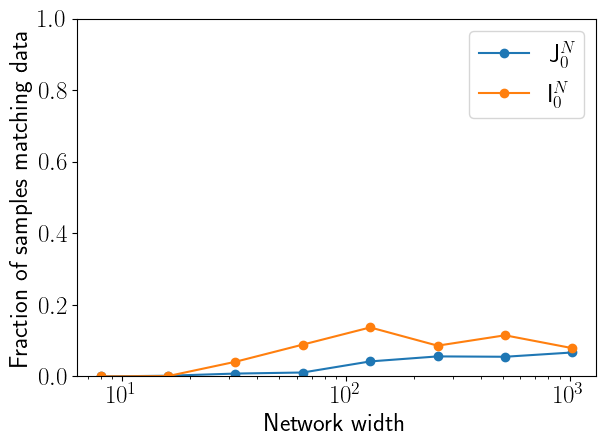

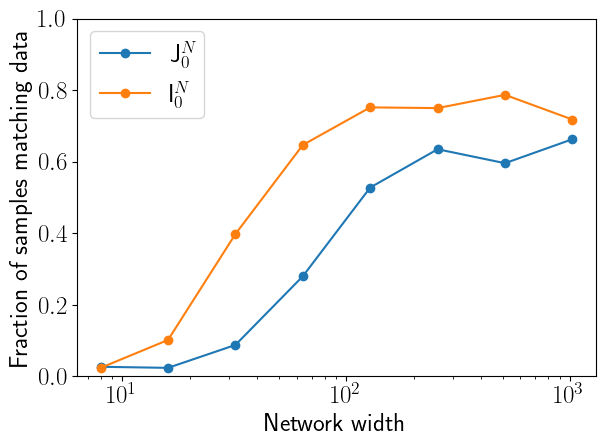

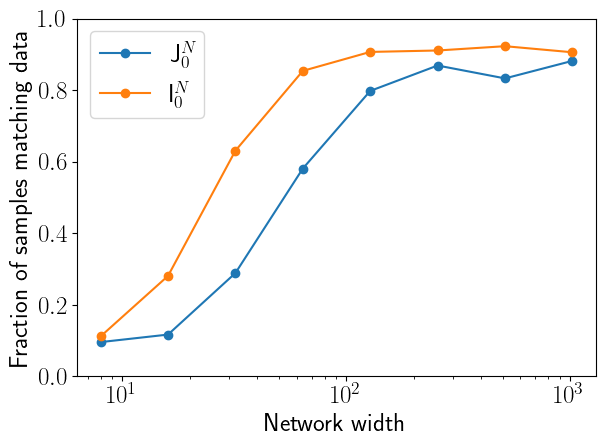

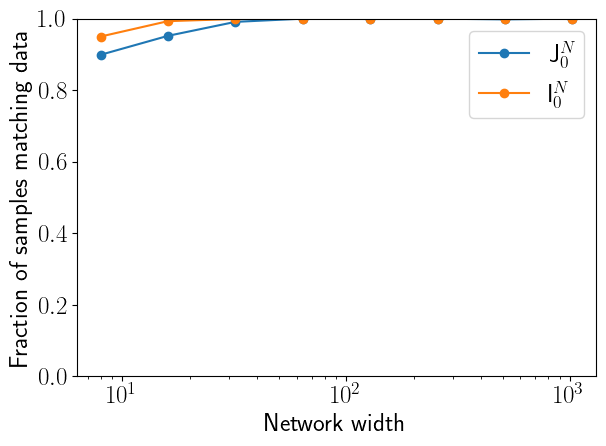

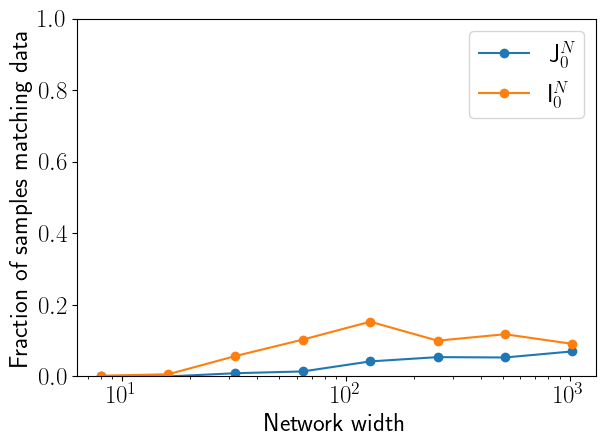

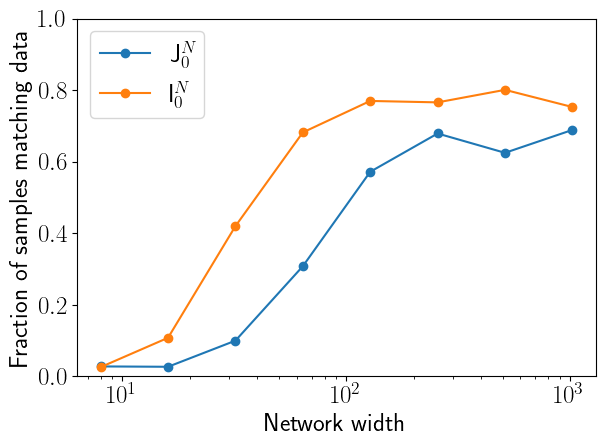

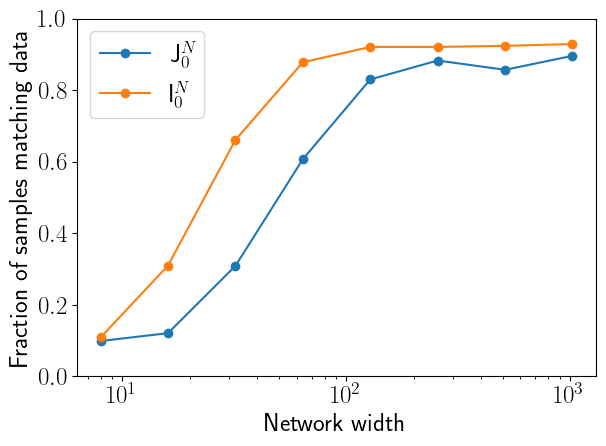

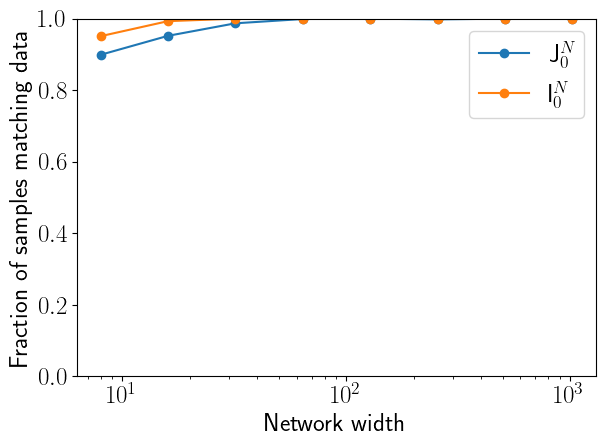

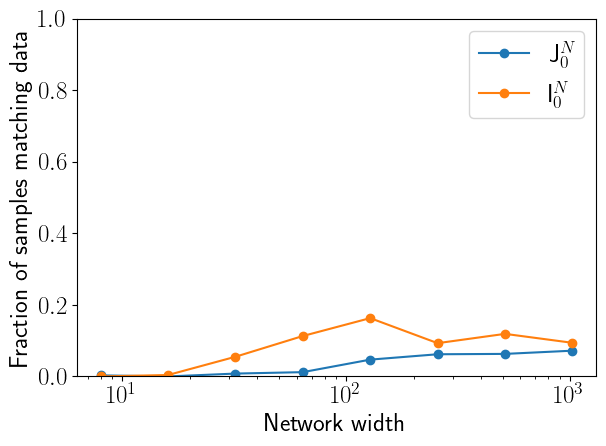

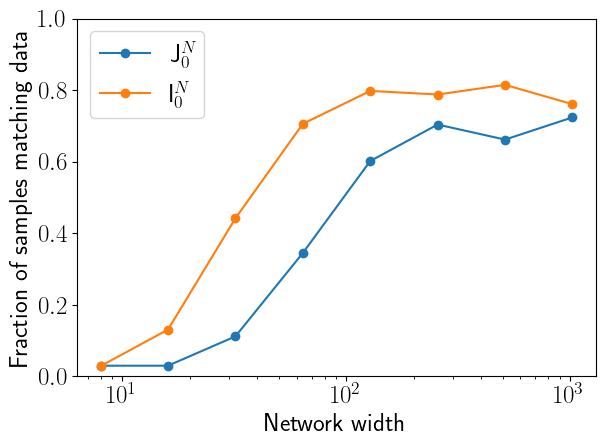

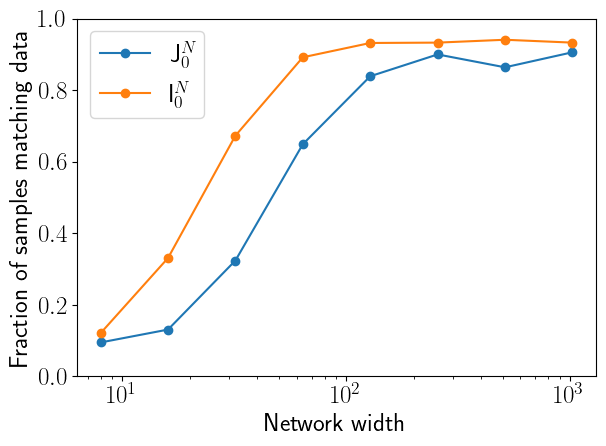

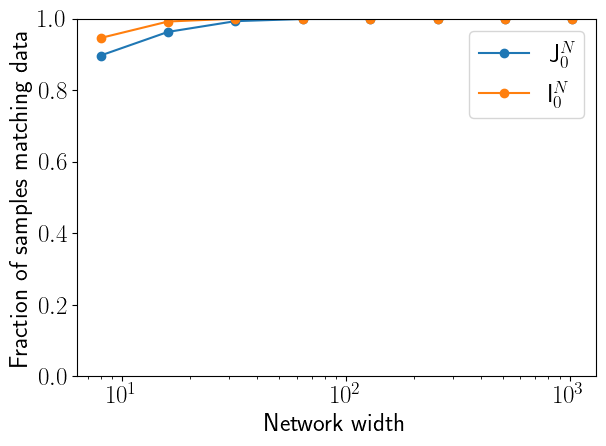

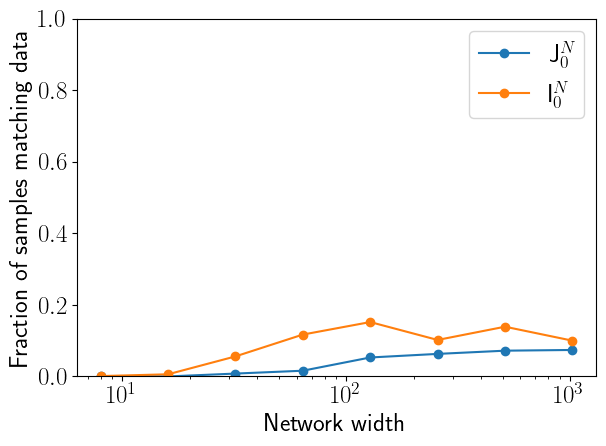

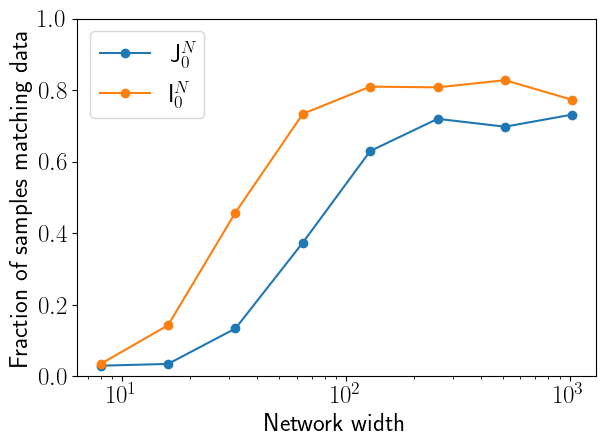

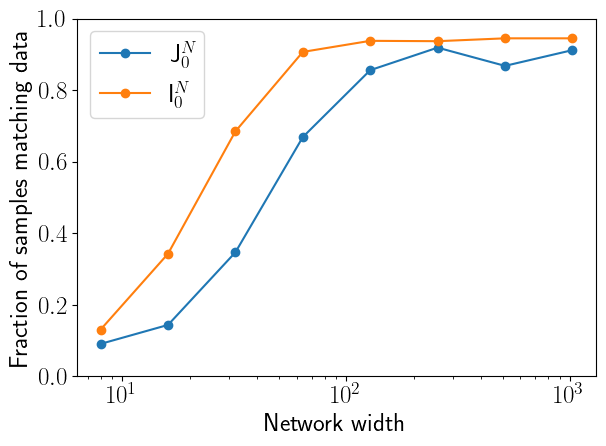

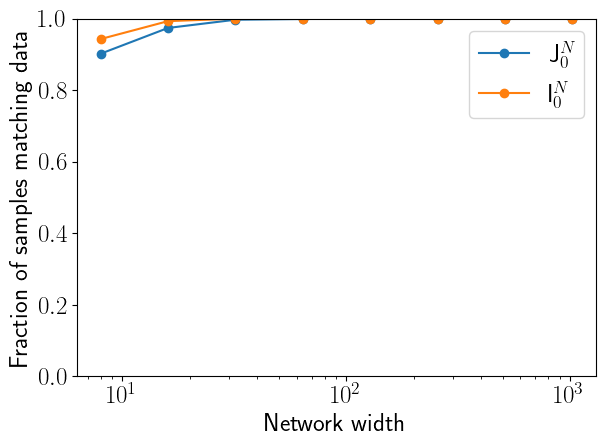

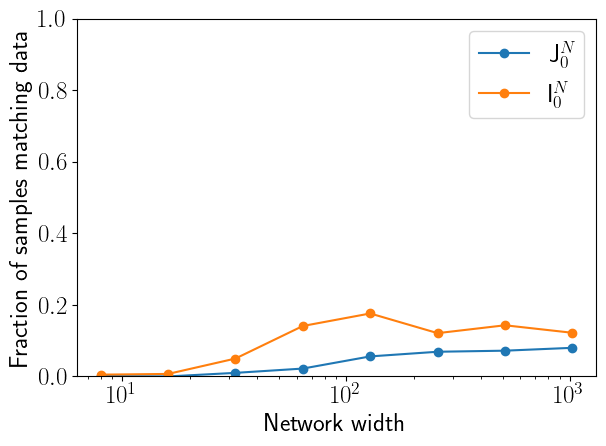

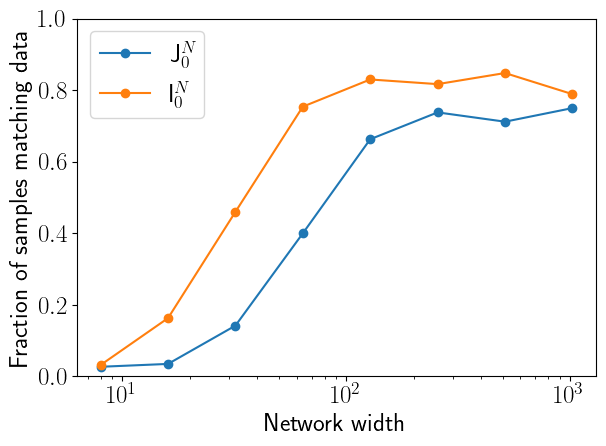

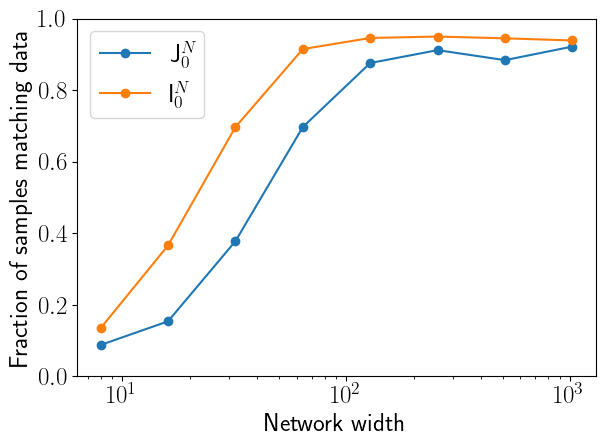

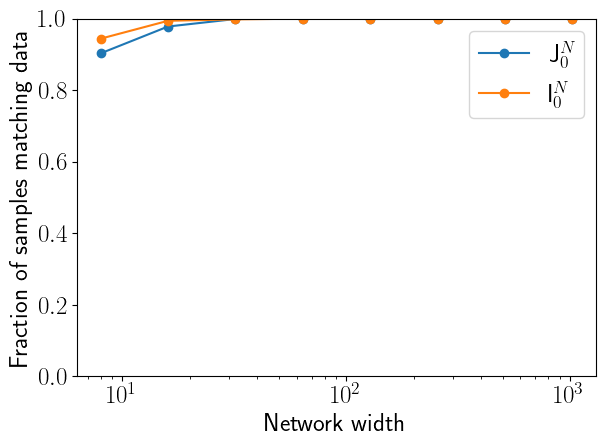

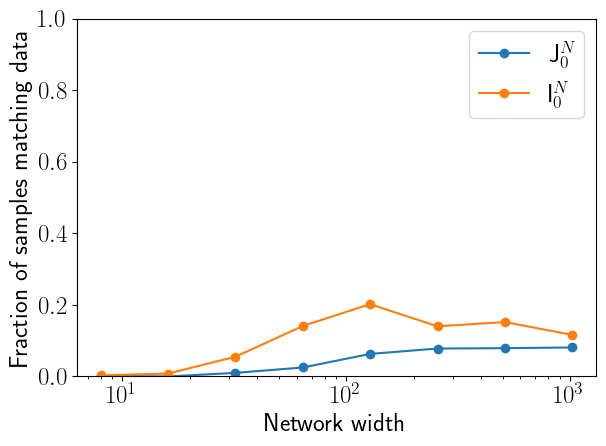

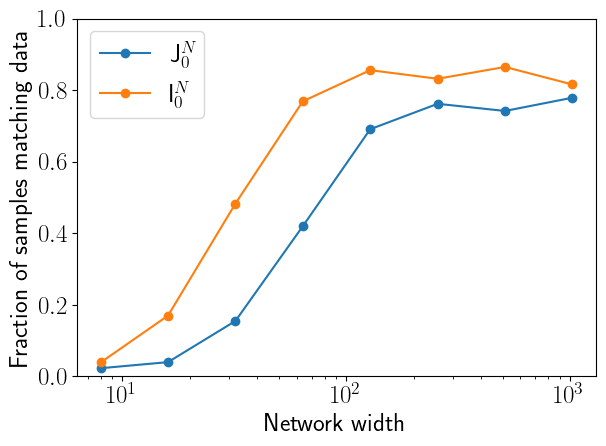

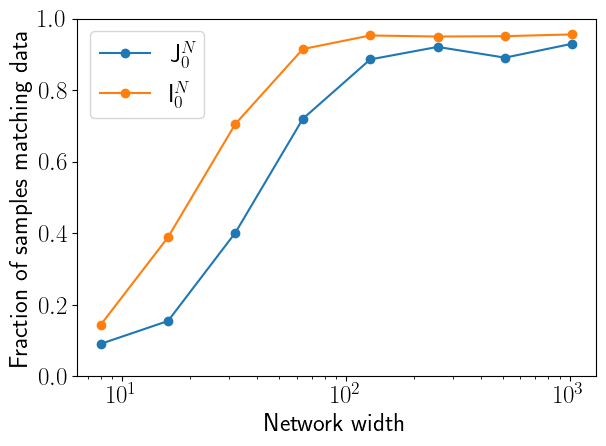

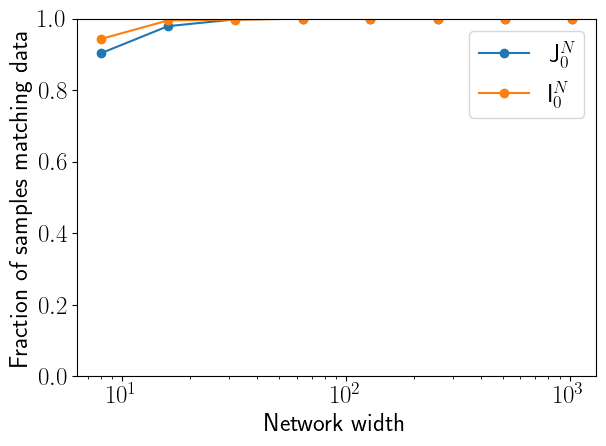

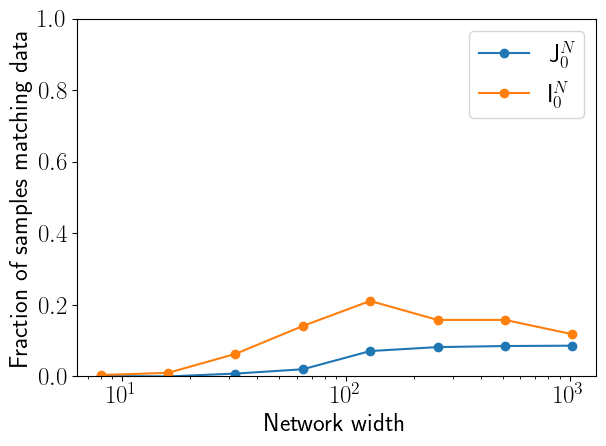

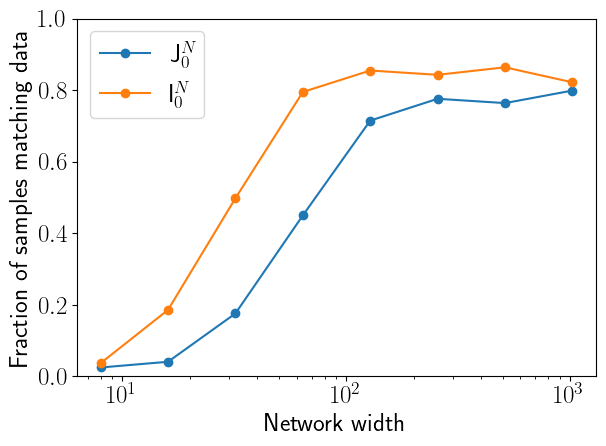

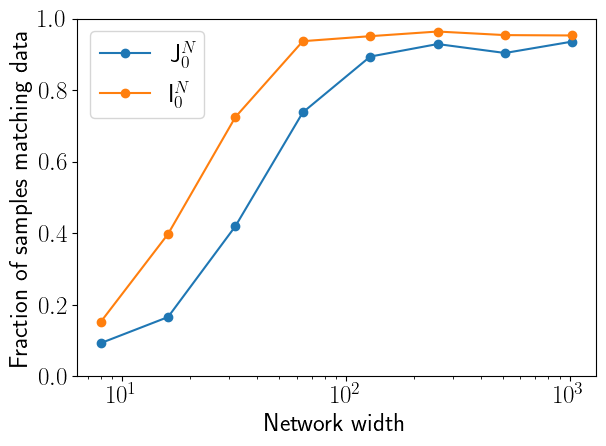

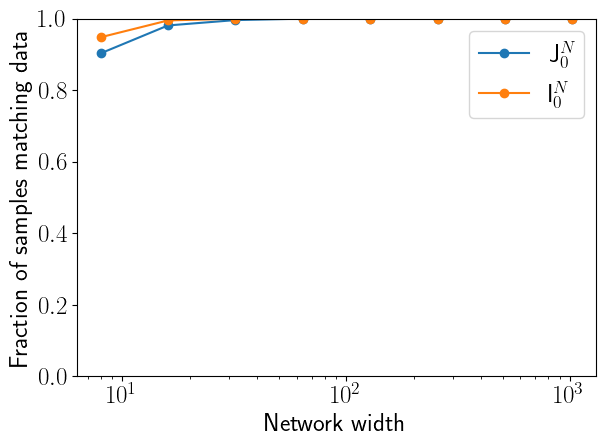

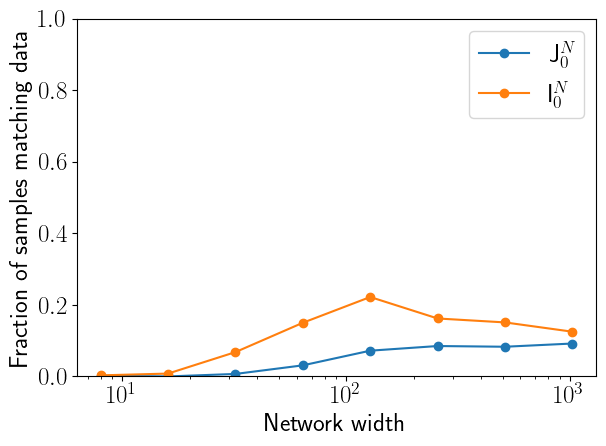

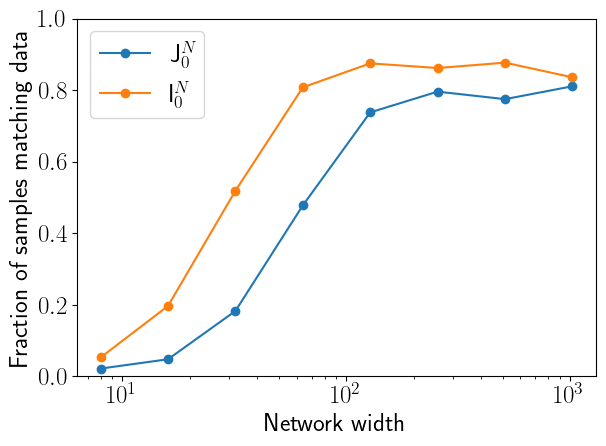

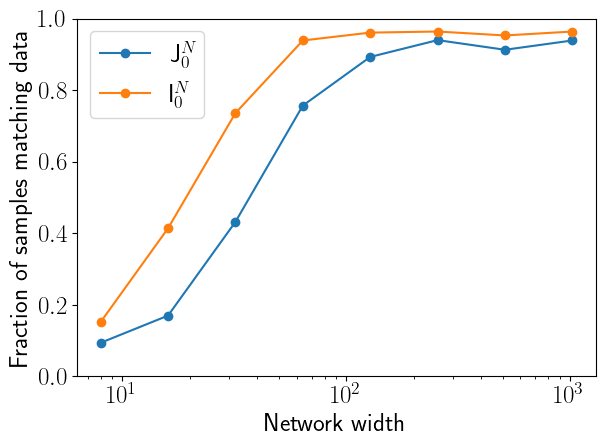

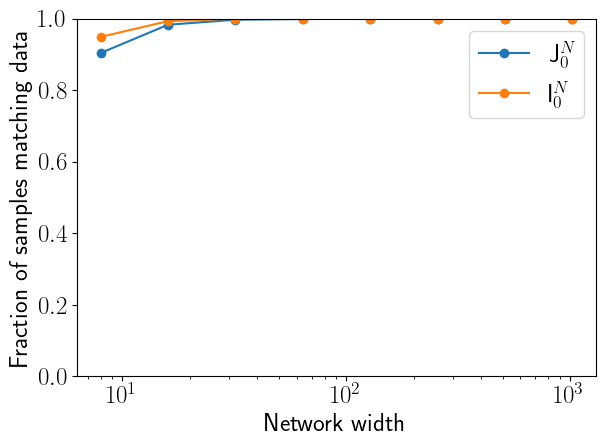

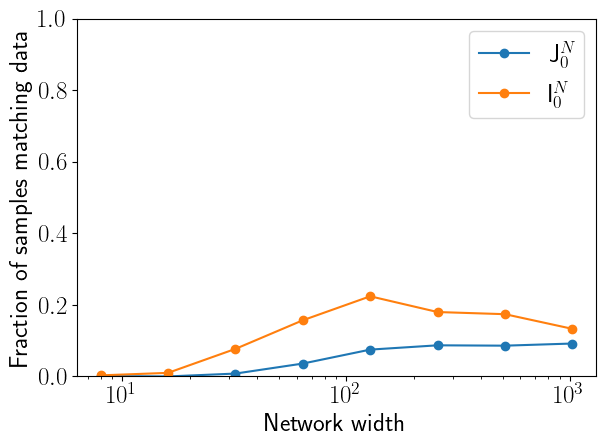

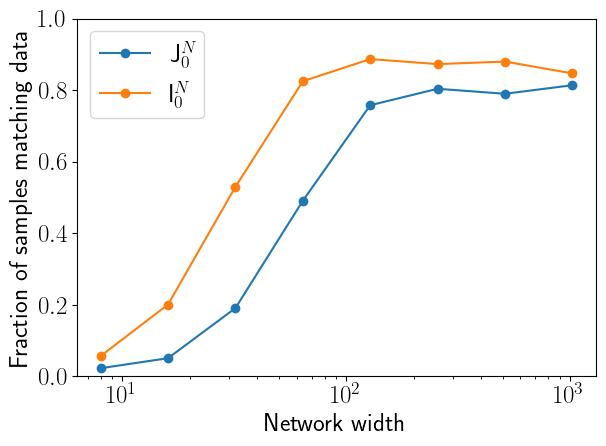

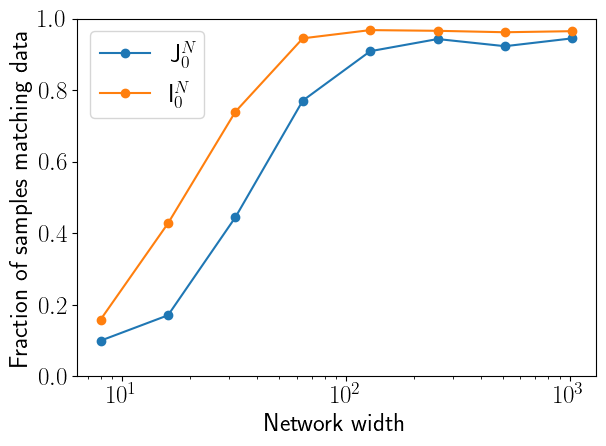

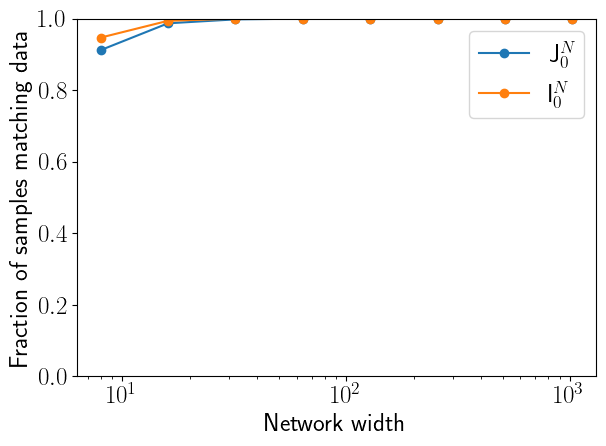

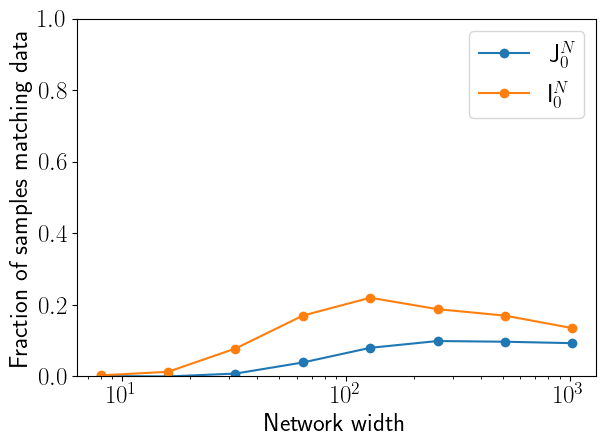

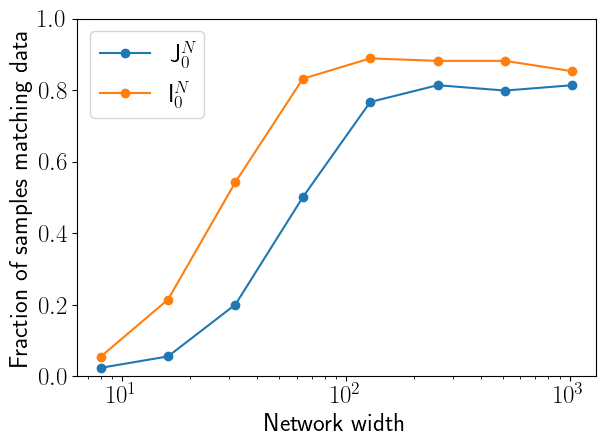

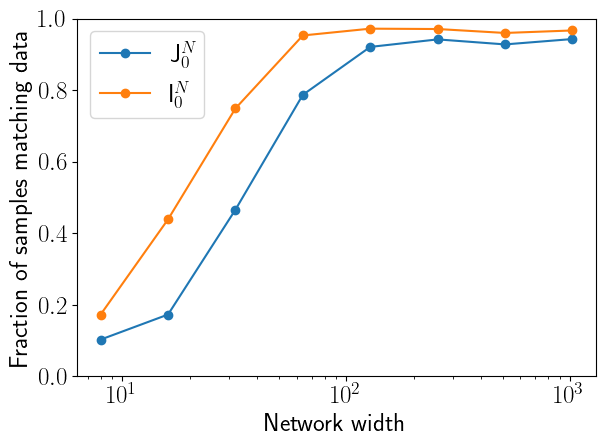

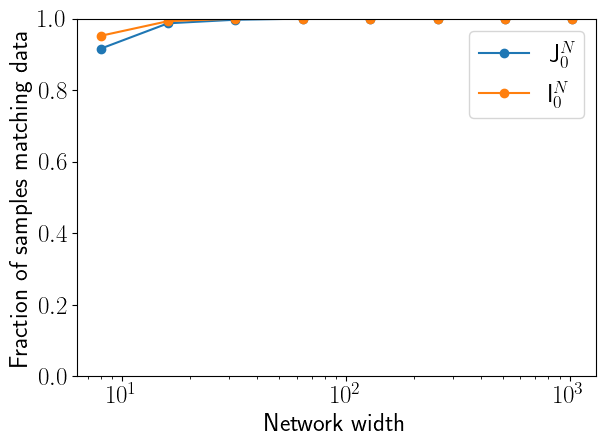

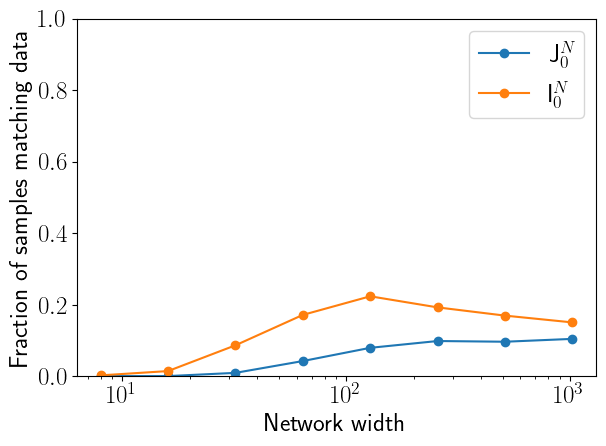

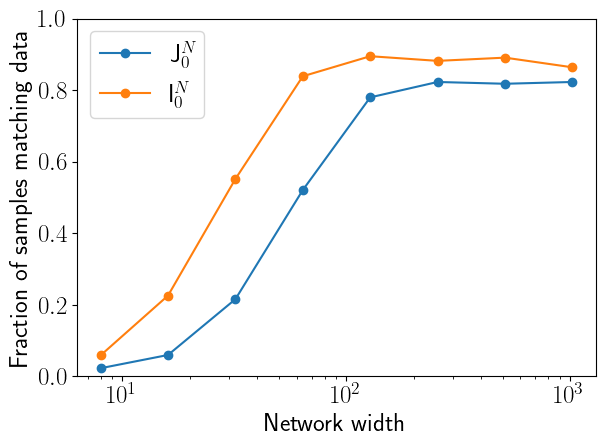

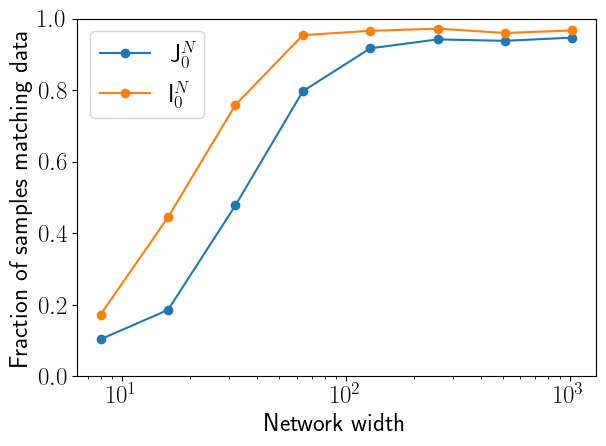

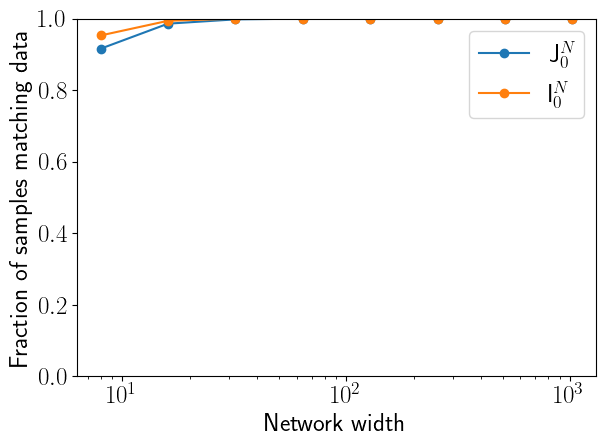

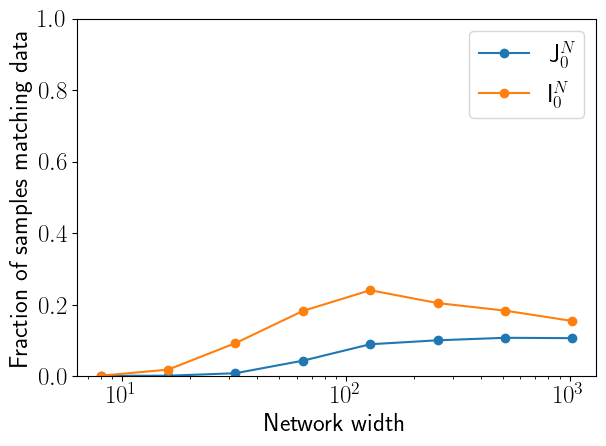

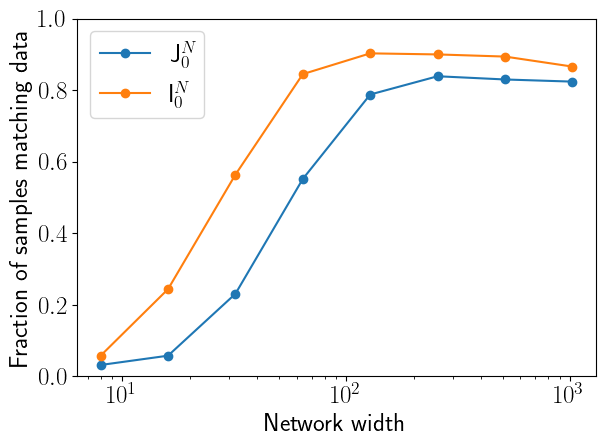

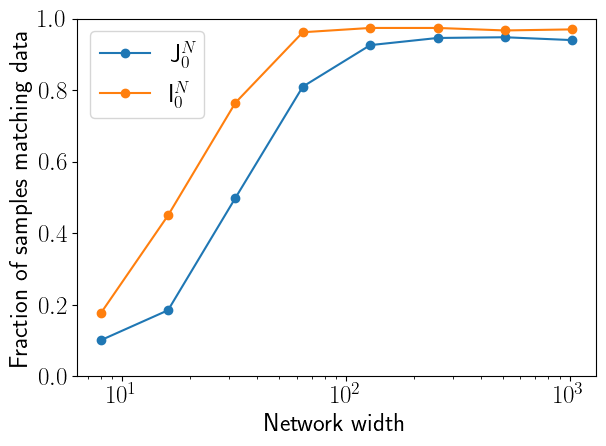

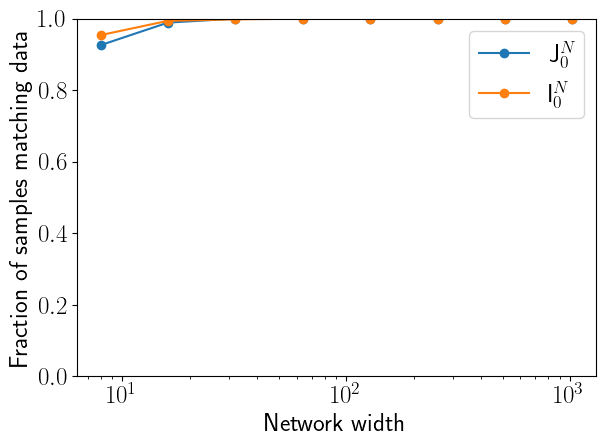

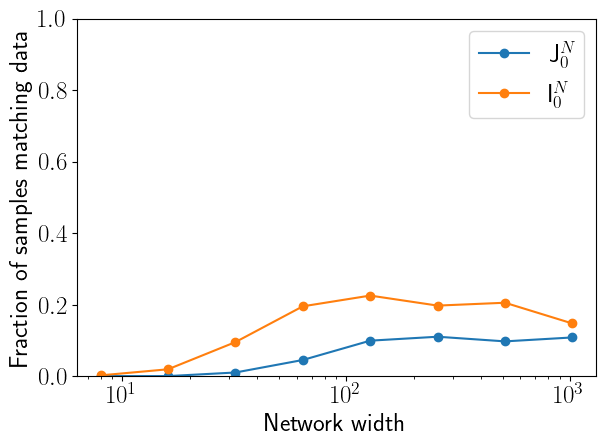

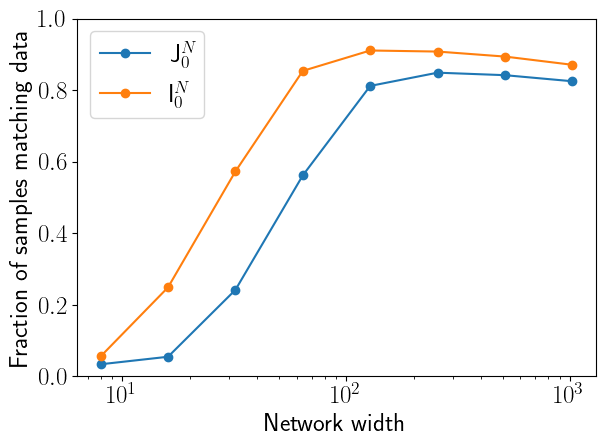

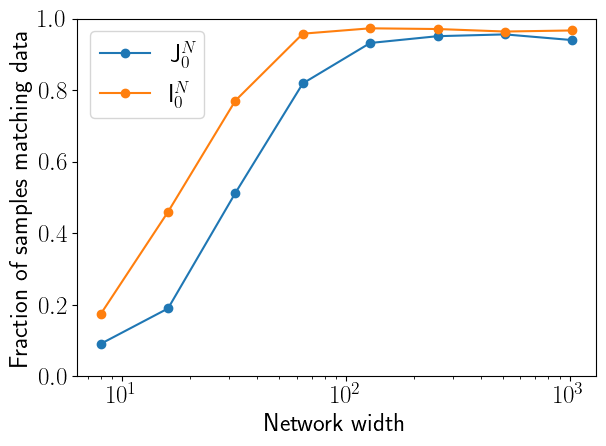

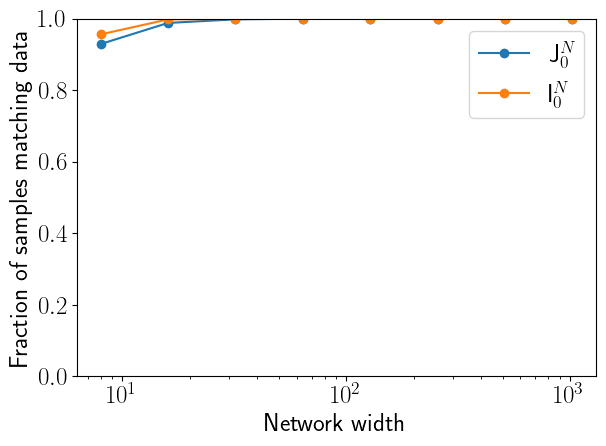

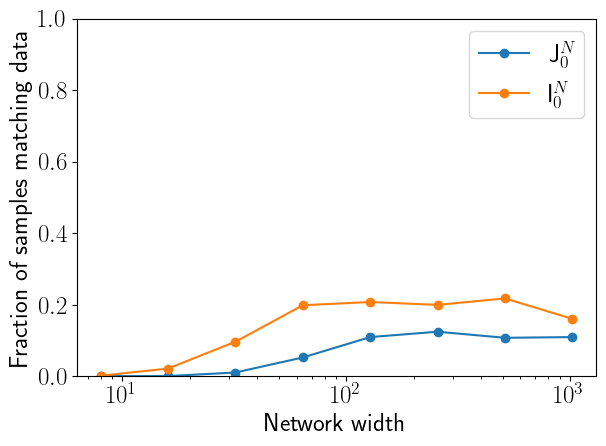

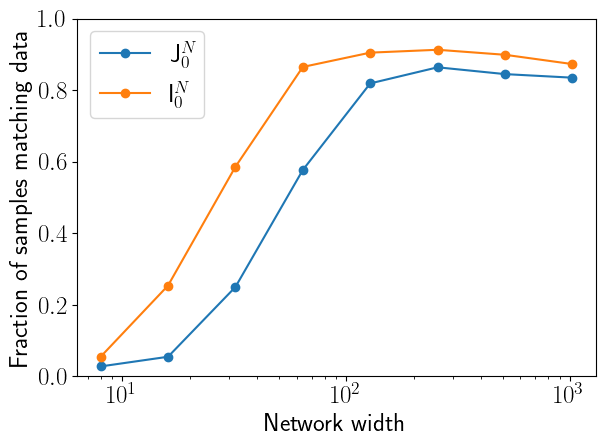

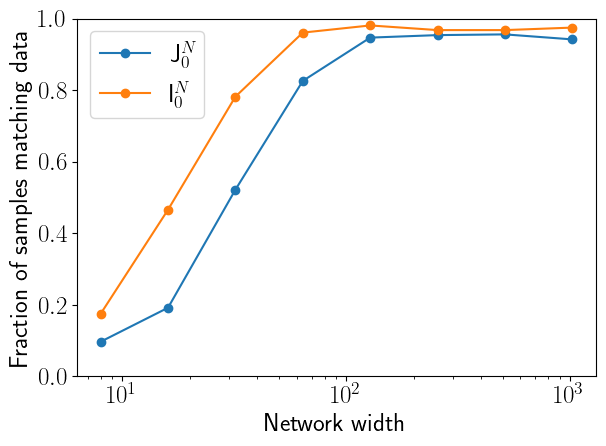

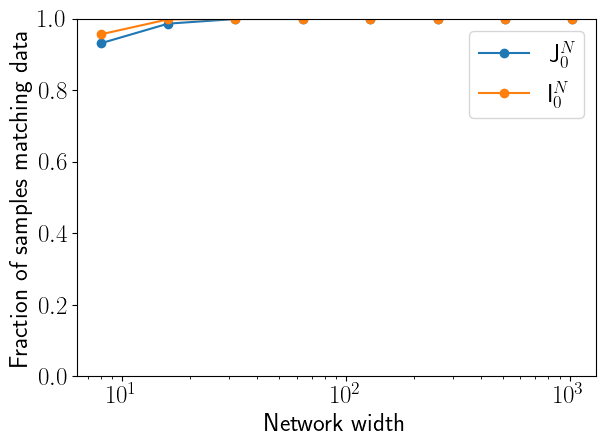

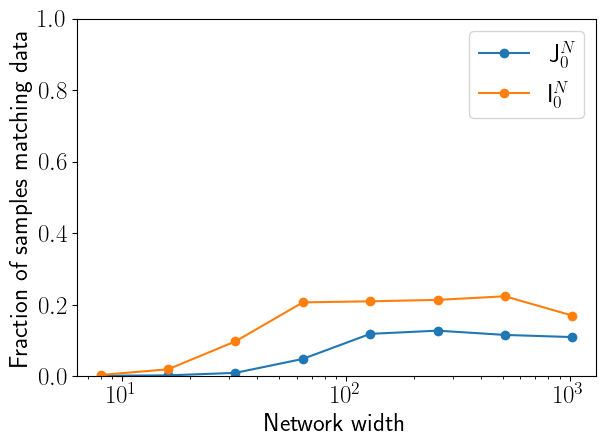

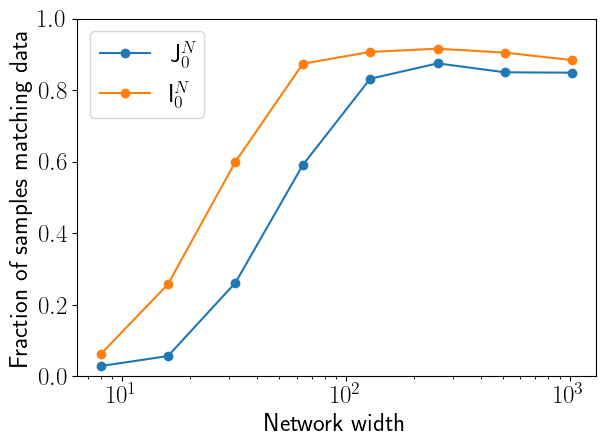

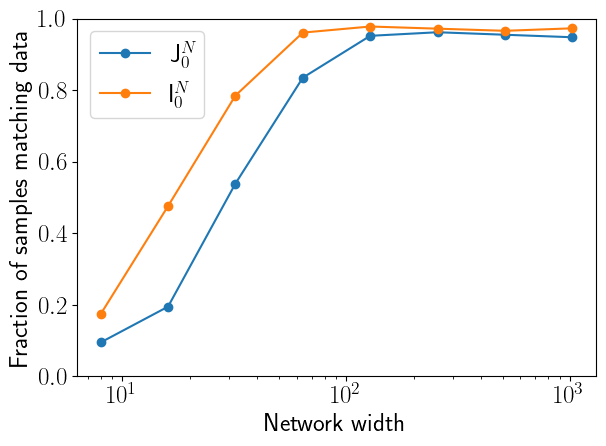

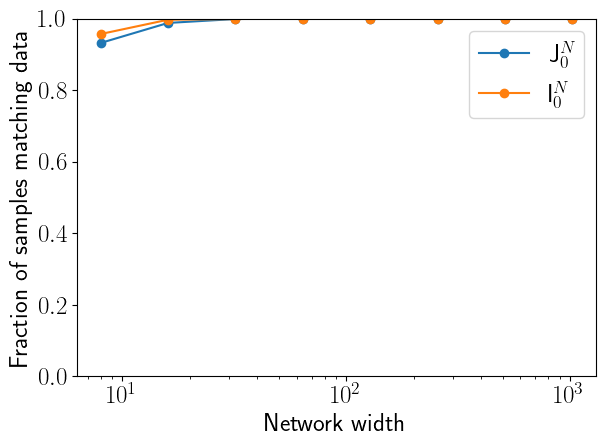

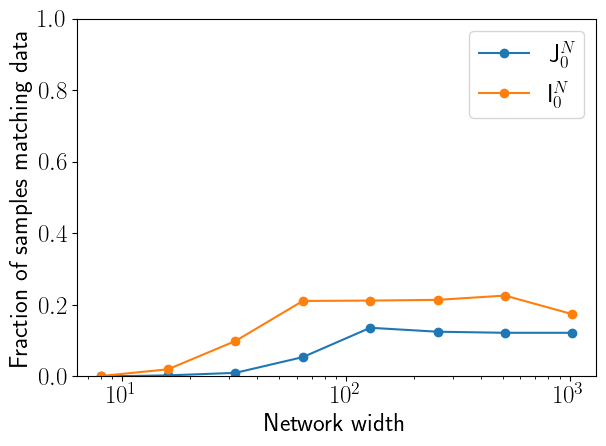

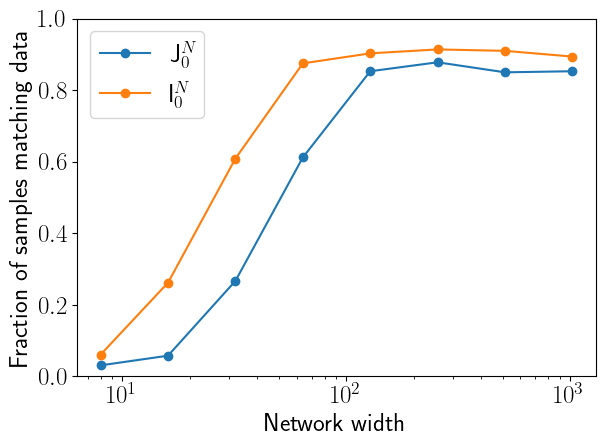

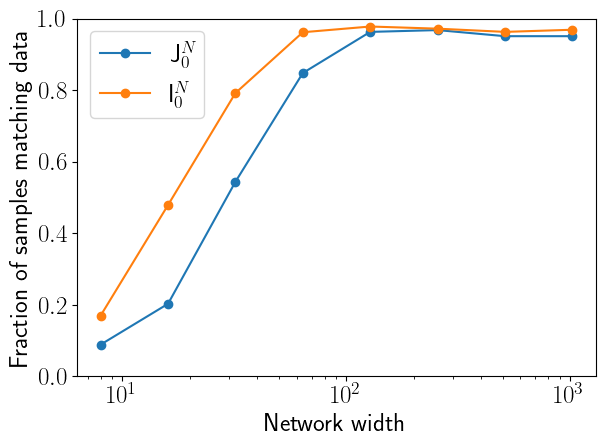

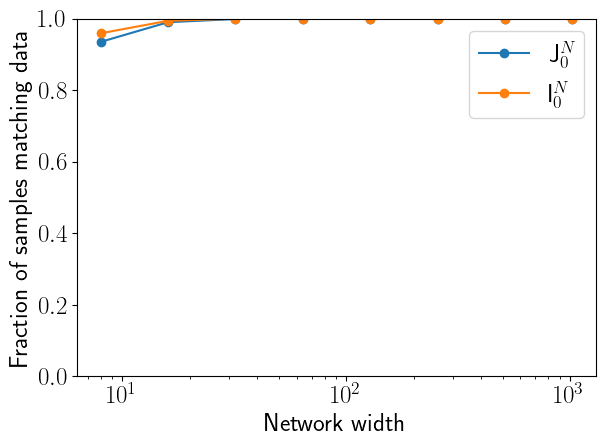

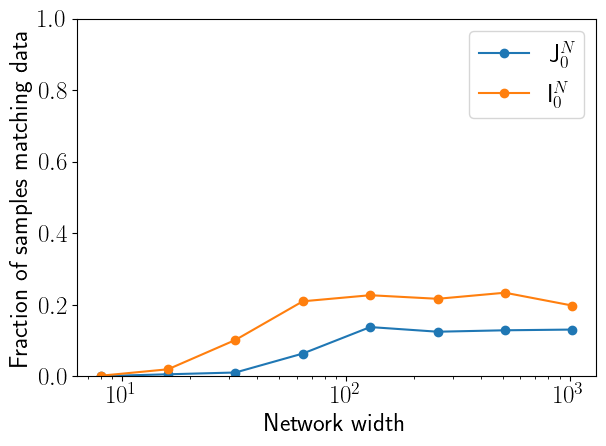

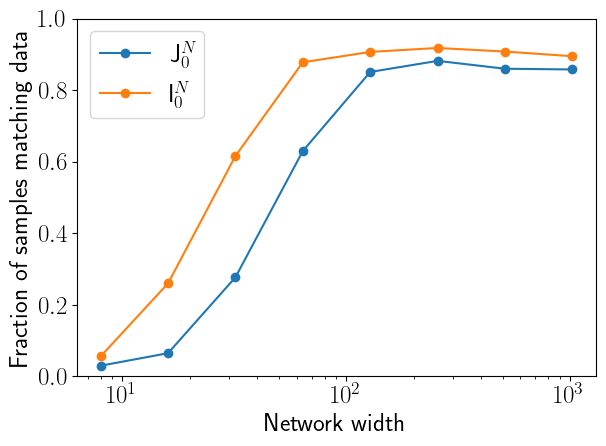

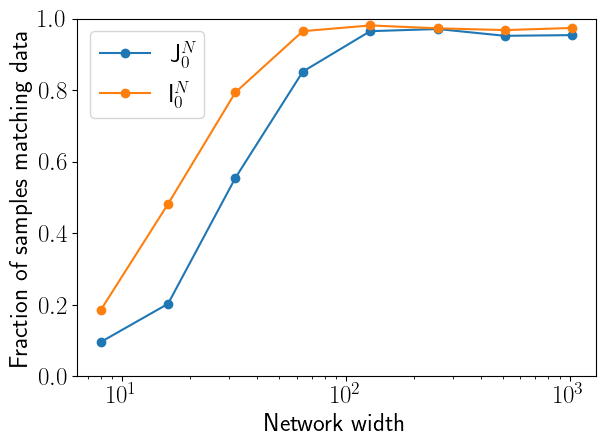

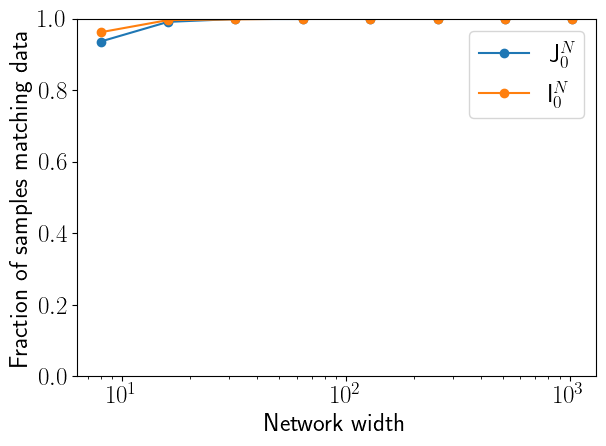

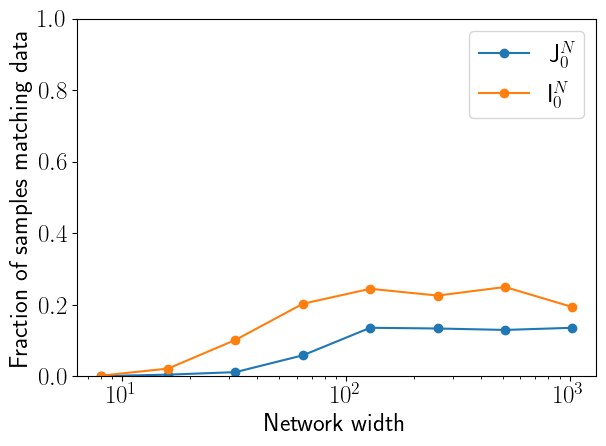

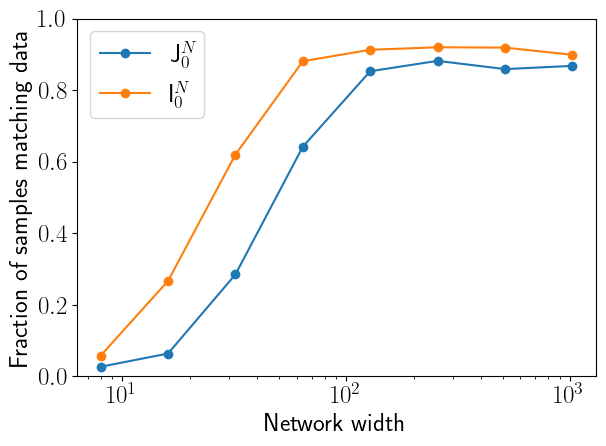

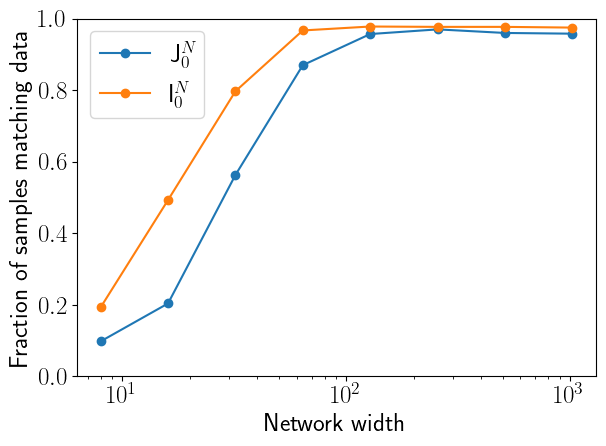

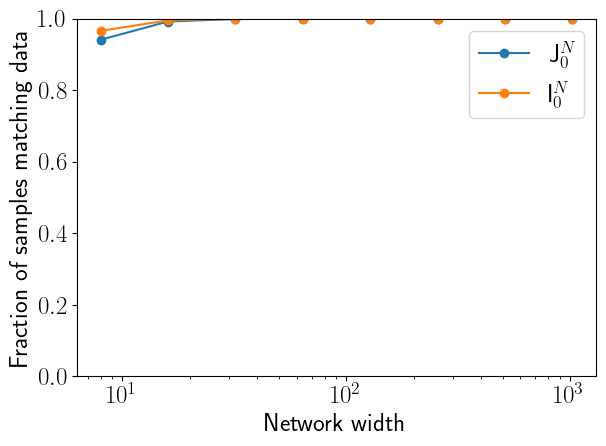

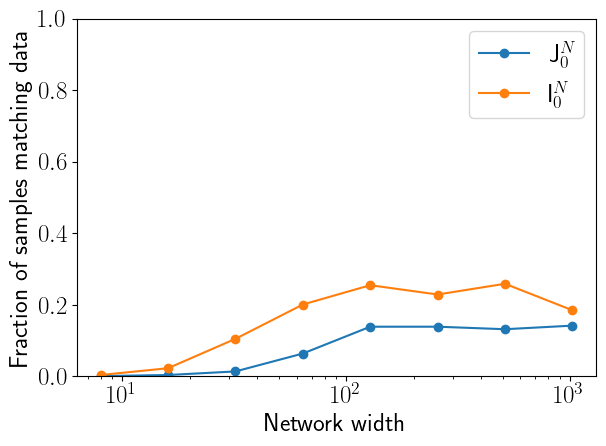

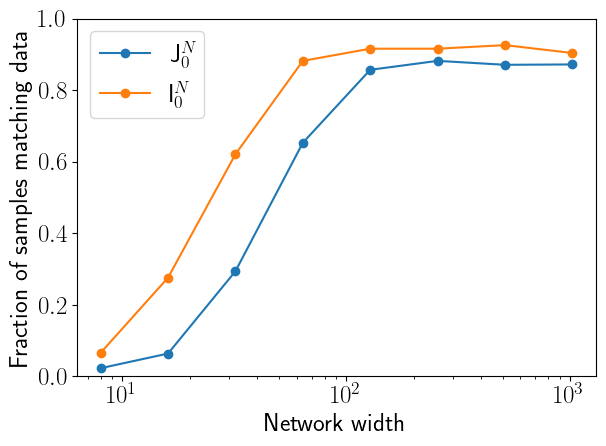

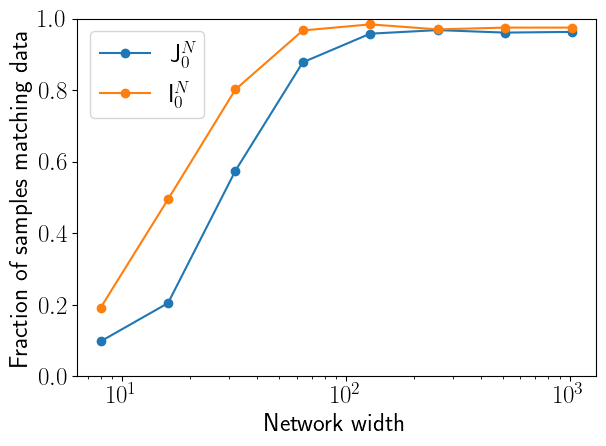

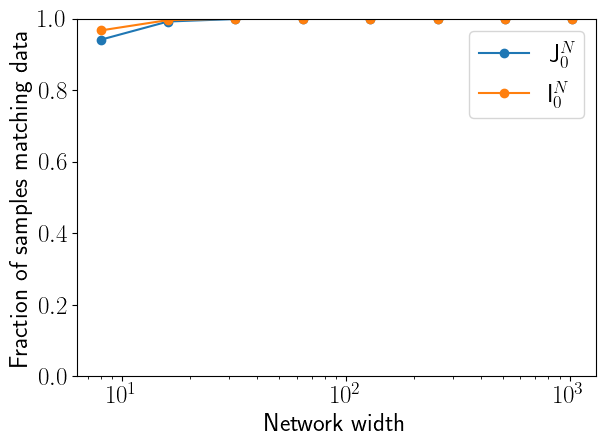

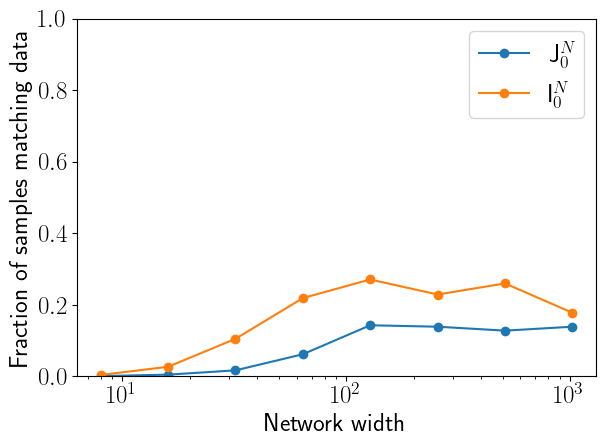

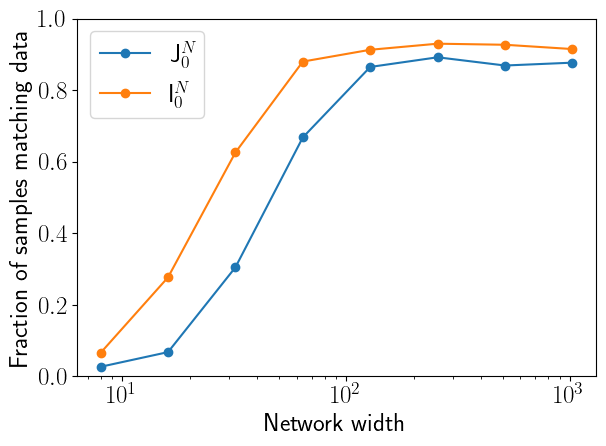

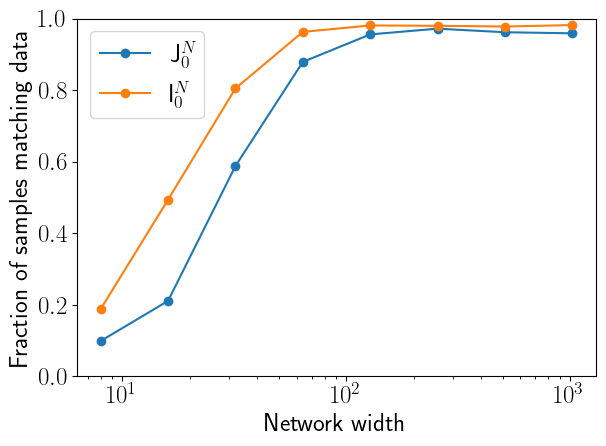

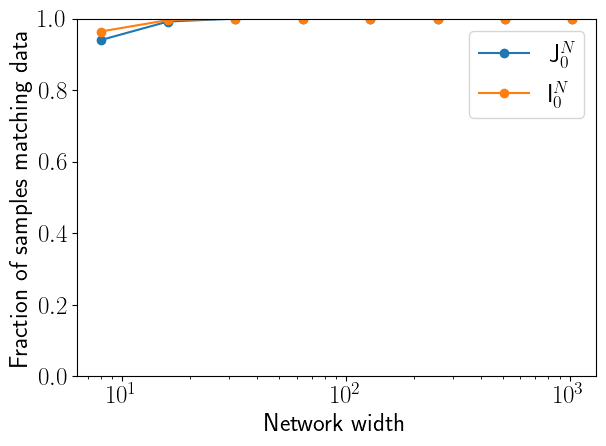

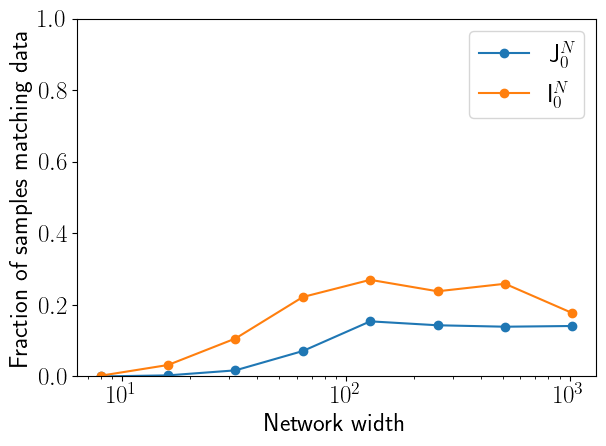

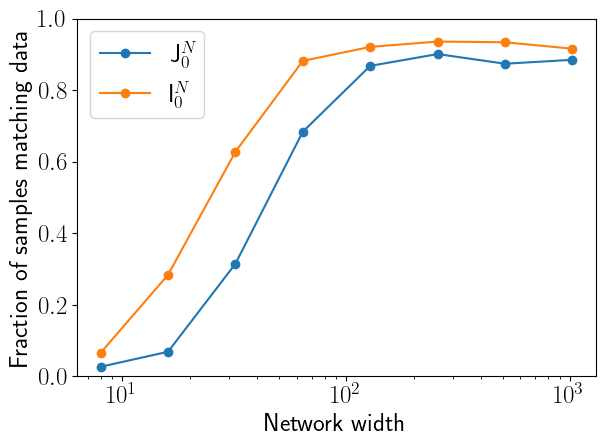

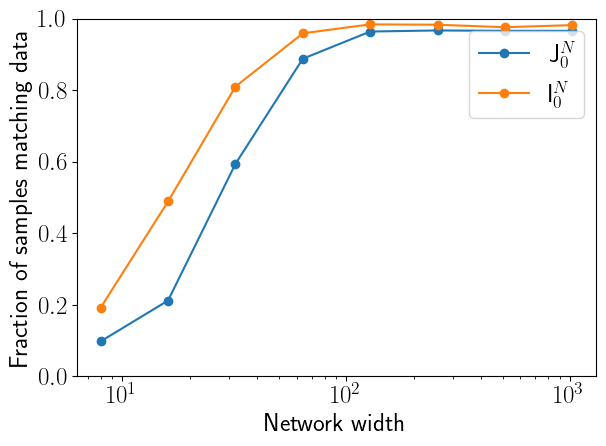

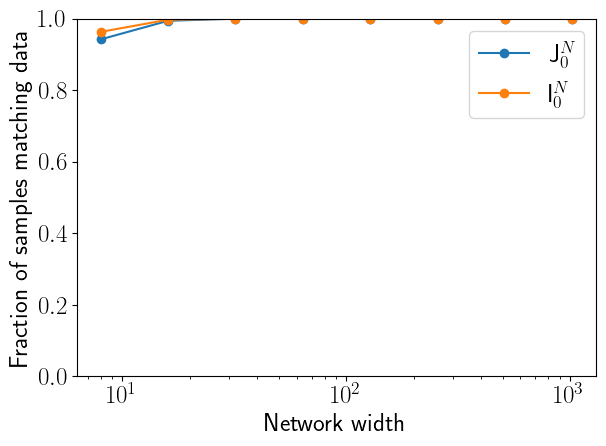

In [ ]:
network_legend = [r'$\mathsf{J}_0^N$',r'$\mathsf{I}_0^N$']

for (l,width) in enumerate(width_list):
    for (j,tolerance) in enumerate(tol_list):
        plt.figure()
        for (k,network) in enumerate(network_names):
            plt.semilogx(epoch_plotting, count_data[j,k,l,:], '-o', label=network_legend[k])
        plt.xlabel(r'Number of epochs')
        plt.ylabel(r'Fraction of samples matching data')
        plt.ylim(0,1)
        plt.tight_layout()
        plt.legend()
        plt.savefig(figures_path+'_width'+str(width)+'_reg_tol'+str(tolerance)+'.pdf')

for (m,epoch) in enumerate(epoch_plotting):
    for (j,tolerance) in enumerate(tol_list):
        plt.figure()
        for (k,network) in enumerate(network_names):
            plt.semilogx(width_list, count_data[j,k,:,m], '-o', label=network_legend[k])
        plt.xlabel(r'Network width')
        plt.ylabel(r'Fraction of samples matching data')
        plt.ylim(0,1)
        plt.tight_layout()
        plt.legend()
        plt.savefig(figures_path+'_epoch'+str(epoch)+'_reg_tol'+str(tolerance)+'.pdf')

/var/folders/tc/106jyy157sv7rxwtk7hgpqf00000gn/T/ipykernel_1178/1012102559.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


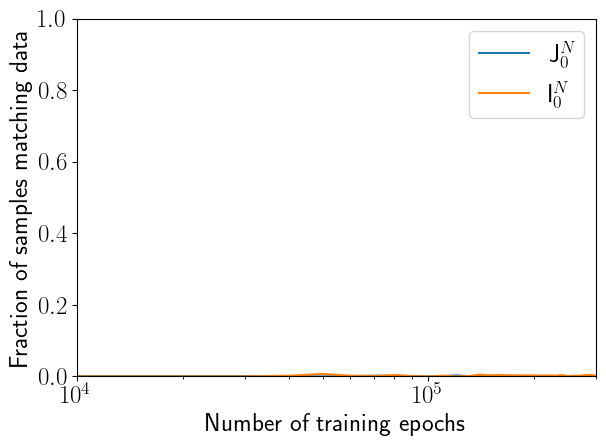

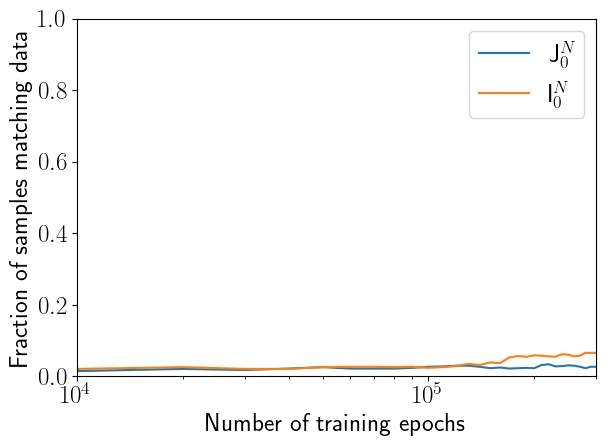

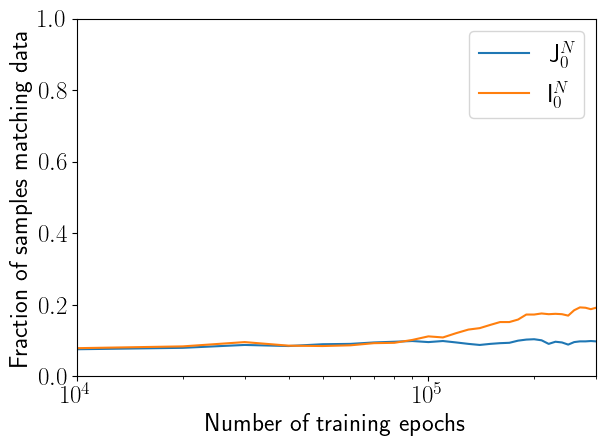

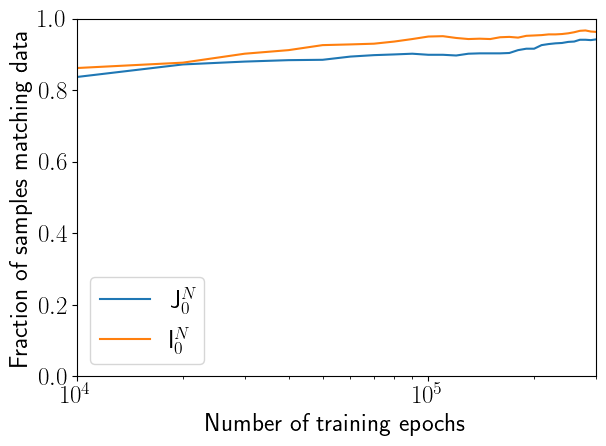

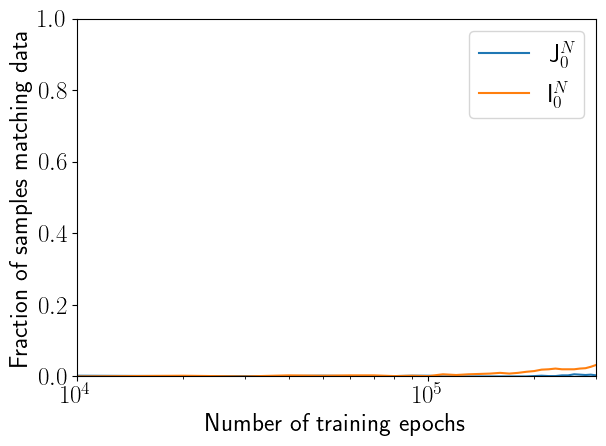

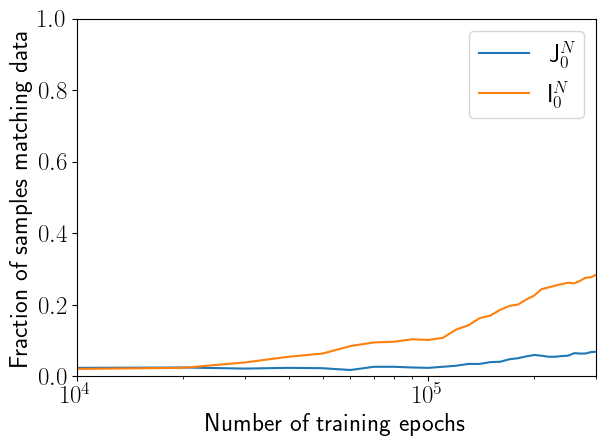

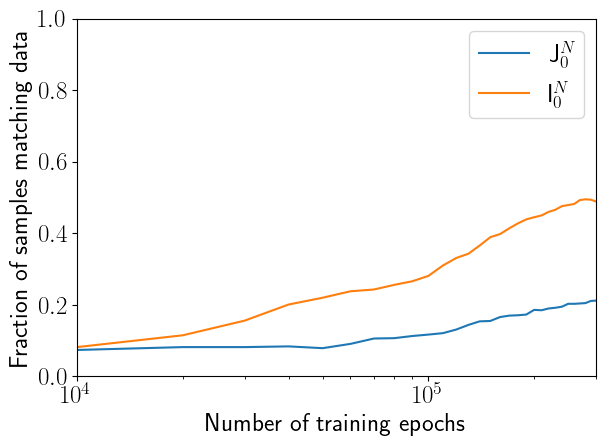

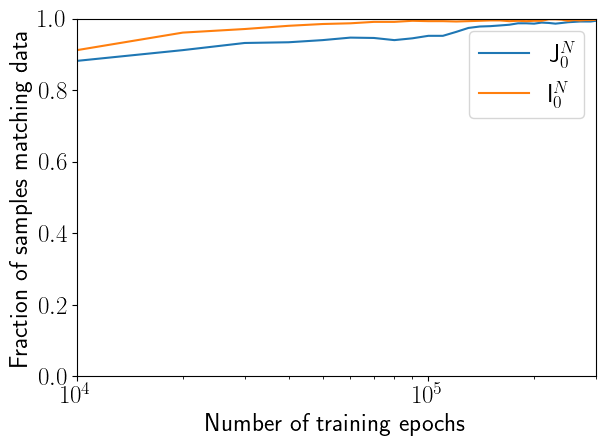

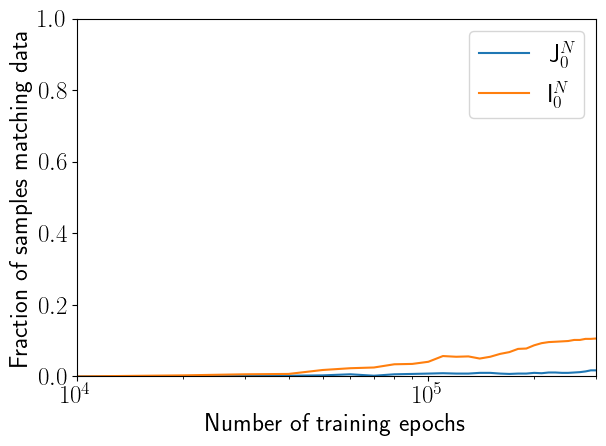

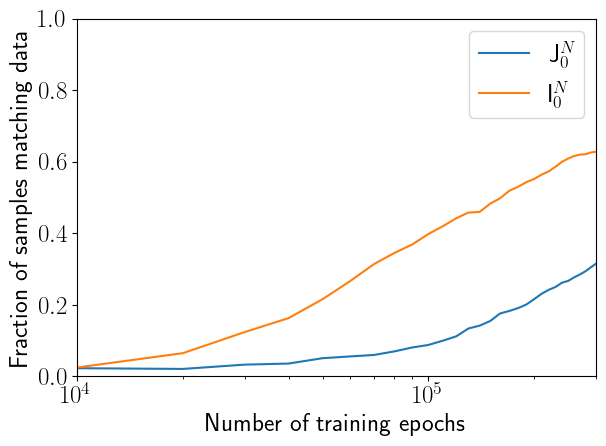

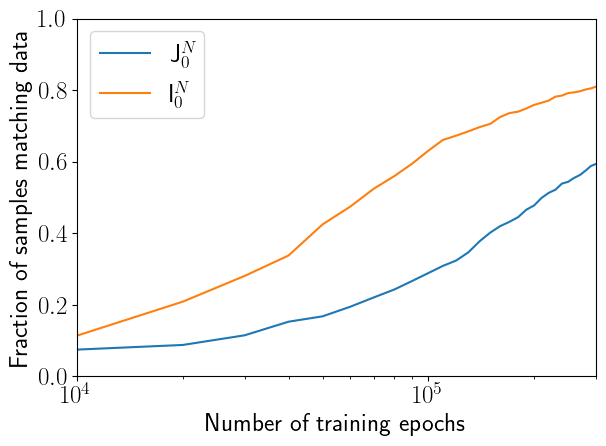

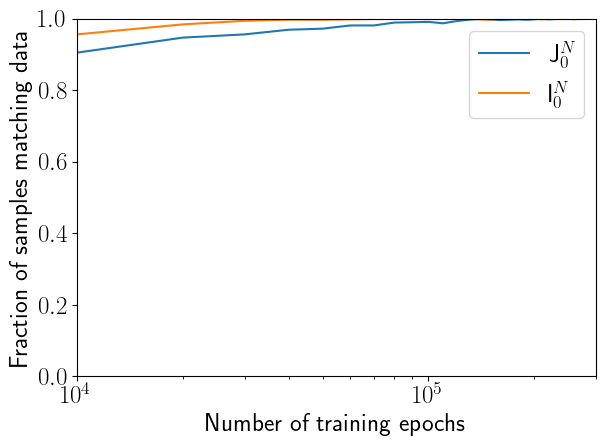

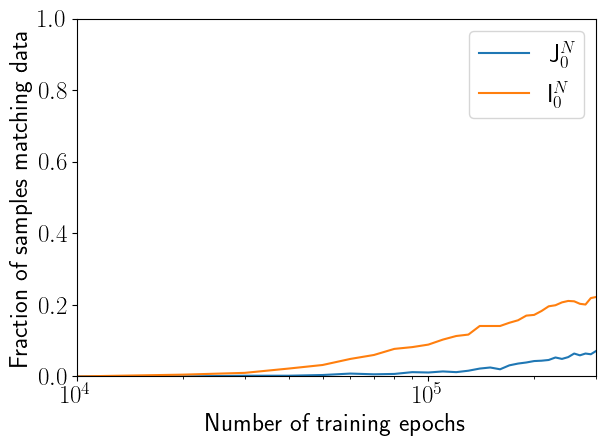

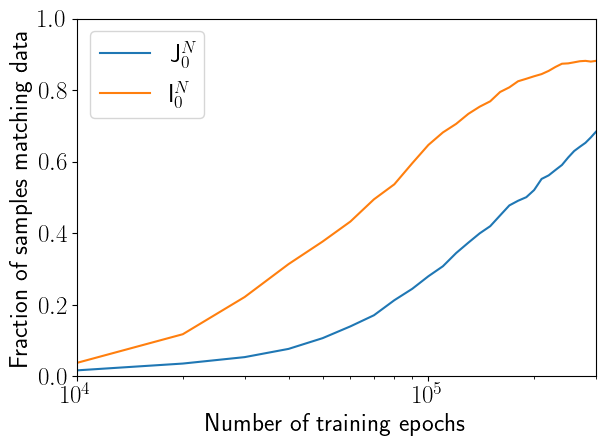

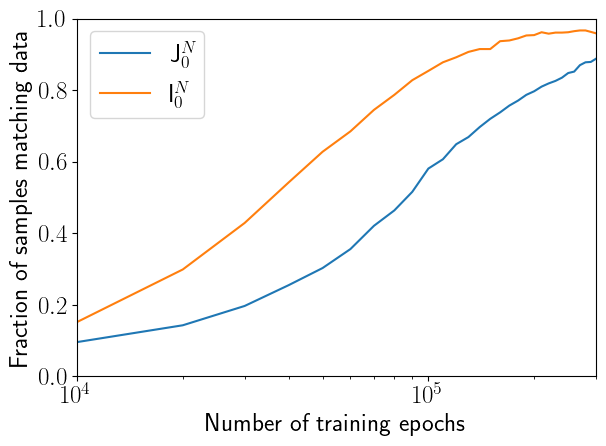

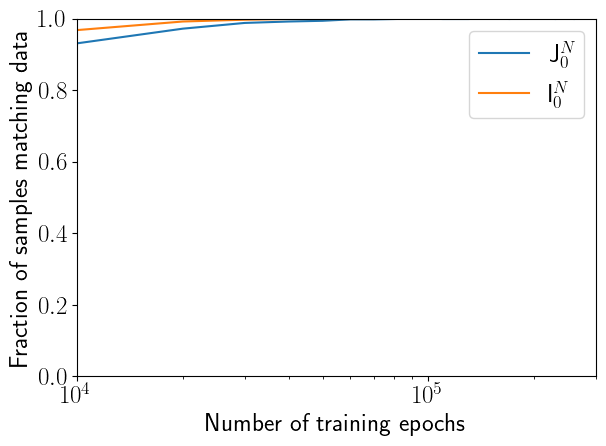

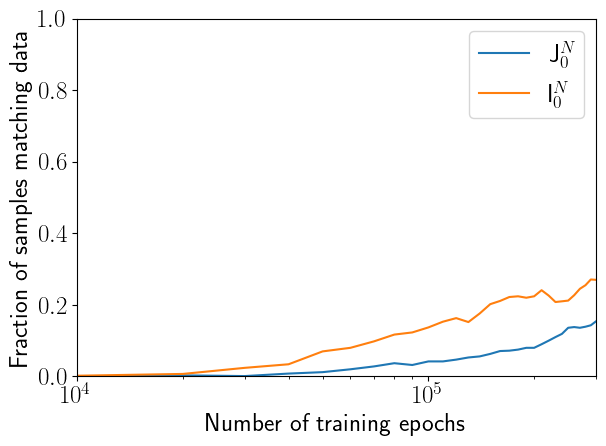

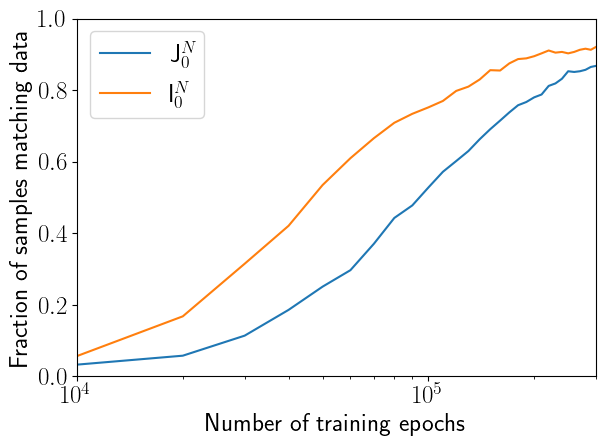

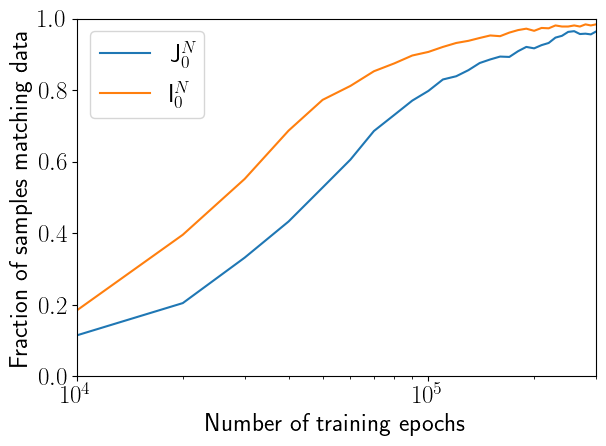

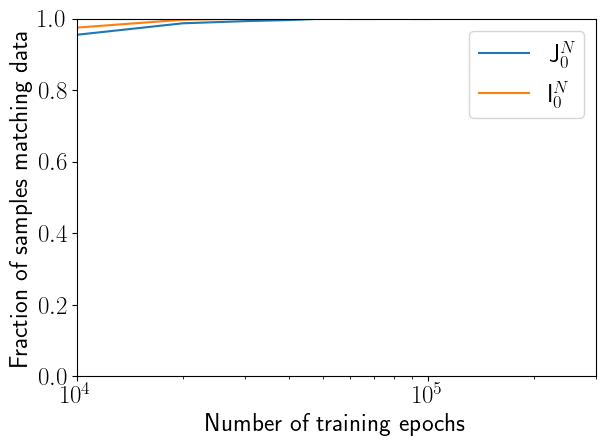

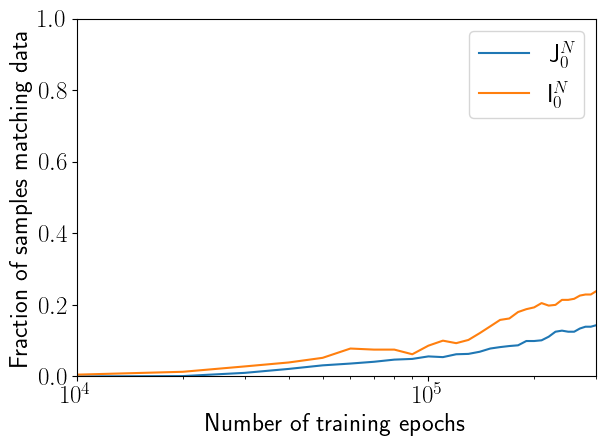

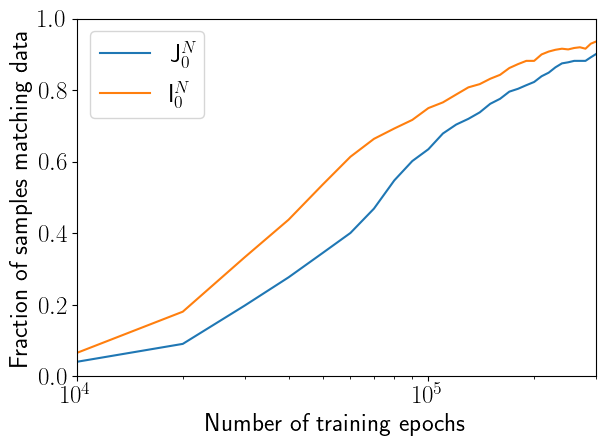

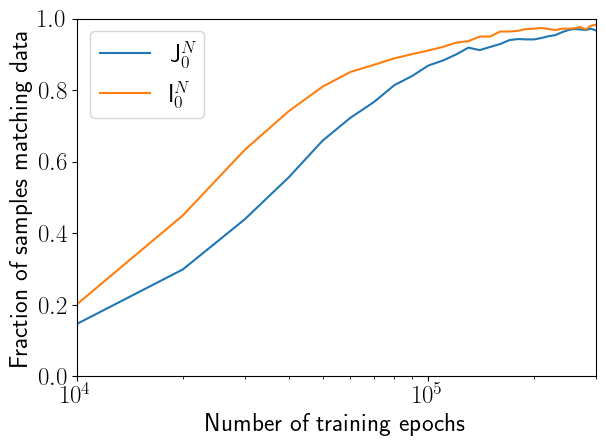

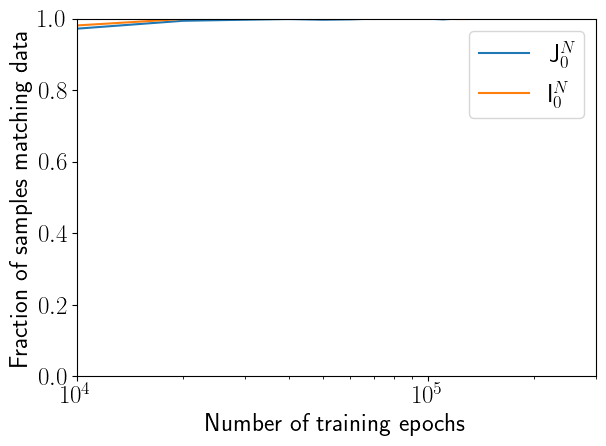

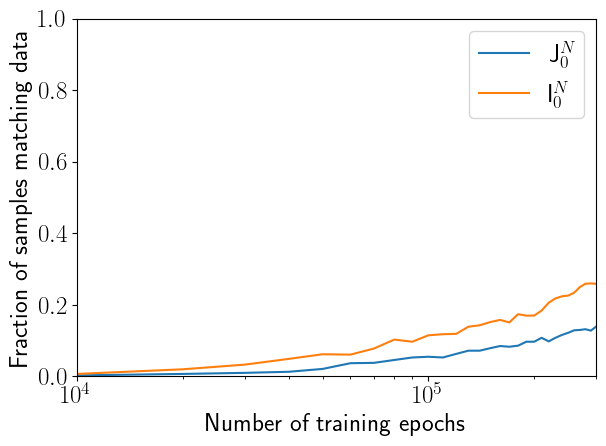

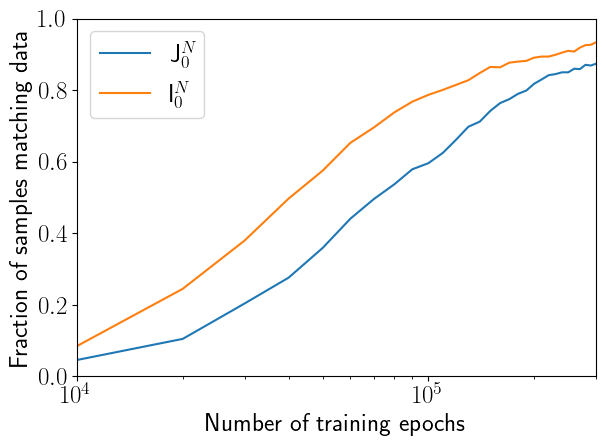

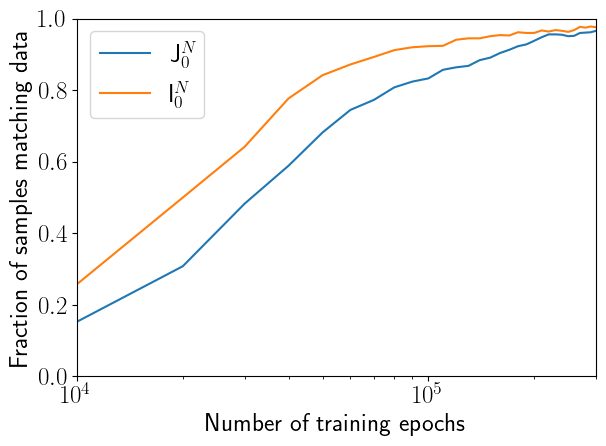

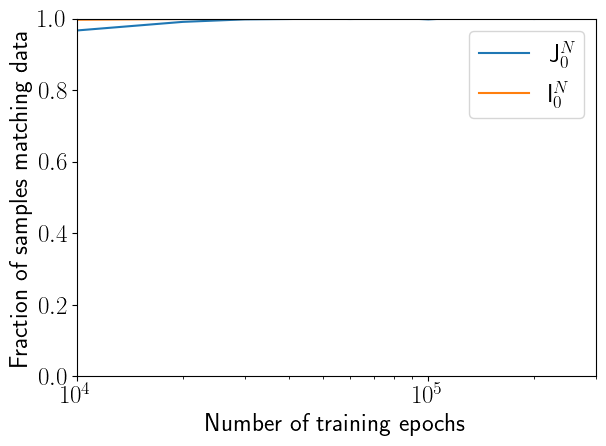

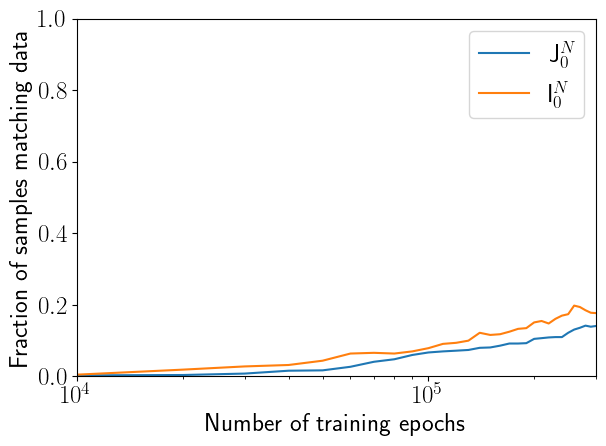

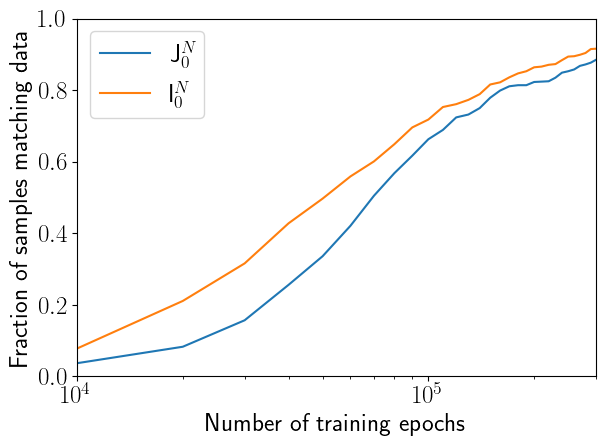

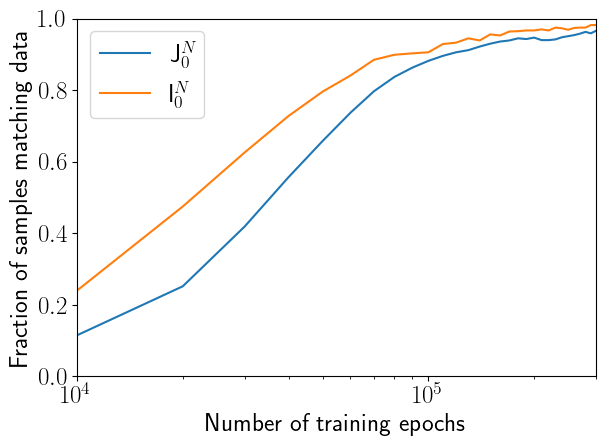

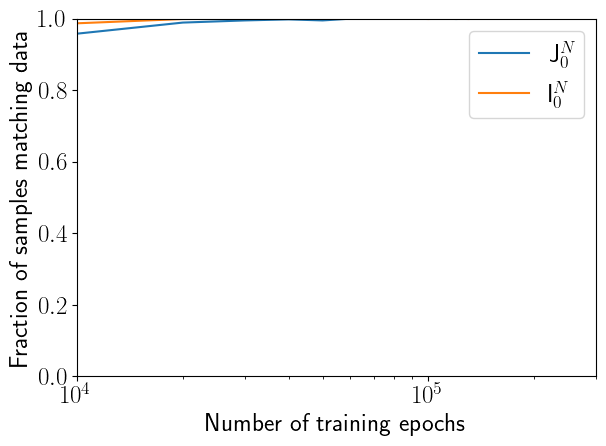

In [ ]:
for (l,width) in enumerate(width_list):
    for (j,tolerance) in enumerate(tol_list):
        plt.figure()
        for (k,network) in enumerate(network_names):
            plt.semilogx(epoch_plotting, count_data[j,k,l,:], '-', linewidth=2, label=network_legend[k])
        plt.xlabel(r'Number of training epochs')
        plt.ylabel(r'Fraction of samples matching data')
        plt.xlim(10000,300000)
        plt.ylim(0,1)
        plt.tight_layout()
        plt.legend()
        plt.savefig(figures_path+'_width'+str(width)+'_reg_tol'+str(tolerance)+'.pdf')
